In [57]:
### import libraries

# format
import pandas as pd

# plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


# math
import numpy as np
import math
from scipy.linalg import inv, det
from numpy.linalg import eig

from scipy import stats

#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

## Introduction
#### Authors: Laura Silvana Alvarez, Florencia Maite Luque and Simon Schmetz
The following project documentation was written as work assignment for the module "Multivariate Analysis" of the Master in Statistics for Data Science at the Universidad Carlos III de Madrid. It contains the Multivariate Analysis of a Kaggel dataset on Sleep Health and Lifestyle (https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset). The work is split into two parts, where in a first part a exploratory data analysis is performed, some data preprocessing steps are taken and a Prinicipal Component Analysis (PCA) is performed. In the second part, distance based metrics will then be applied to identify clusters emerging from the PCA. 

In [58]:
# load data
data_raw = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

 The dataset at hand is composed out of the collumns shown in the table below. It has been modified compared to the kaggle source data by turning the "Sleep Disorder" Variable into a binary variable (yes/no) and by seperating the blood pressure variables into the two variables blood pressure systolic and blood pressure diastolic. The resulting data set is composed out of the variables shown in the following table. 

| **Variable**                    | **Description**                                                                                              |
|---------------------------------|--------------------------------------------------------------------------------------------------------------|
| Person ID                       | An identifier for each individual.                                                                           |
| Gender                          | The gender of the person (Male/Female).                                                                      |
| Age                             | The age of the person in years.                                                                              |
| Occupation                      | The occupation or profession of the person.                                                                  |
| Sleep Duration (hours)          | The number of hours the person sleeps per day.                                                               |
| Quality of Sleep (scale: 1-10)  | A subjective rating of the quality of sleep, ranging from 1 to 10.                                          |
| Physical Activity Level (minutes/day) | The number of minutes the person engages in physical activity daily.                               |
| Stress Level (scale: 1-10)      | A subjective rating of the stress level experienced by the person, ranging from 1 to 10.                    |
| BMI Category                    | The BMI category of the person (e.g., Underweight, Normal, Overweight).                                      |
| Blood Pressure (systolic) | The blood pressure measurement of the person (systolic pressure)|
| Blood Pressure (diastolic) |  The blood pressure measurement of the person (diastolic pressure)|
| Heart Rate (bpm)                | The resting heart rate of the person in beats per minute.                                                    |
| Daily Steps                     | The number of steps the person takes per day.                                                                |
| Sleep Disorder                  | The presence or absence of a sleep disorder in the person (Binary)|

In [59]:
### Preprocess Data
data = data_raw.copy()

# rename columns for easier use
rename_dict = {
    'Person ID':'person_id',
    'Gender': 'gender',
    'Age':'age',
    'Occupation':'occupation',
    'Sleep Duration':'sleep_duration',
    'Quality of Sleep':'quality_of_sleep',
    'Physical Activity Level':'physical_activity_level',
    'Stress Level':'stress_level',
    'BMI Category':'bmi_category', 
    'Blood Pressure':'blood_pressure', 
    'Heart Rate':'heart_rate', 
    'Daily Steps':'daily_steps',
    'Sleep Disorder':'sleep_disorder' 
}
data.rename(columns=rename_dict, inplace=True)

# change dtype
data['quality_of_sleep'] = data['quality_of_sleep'].astype(str)
data['stress_level'] = data['stress_level'].astype(str)

# make sleep disorder binary
data['sleep_disorder'] = data['sleep_disorder'].map(lambda x: '1' if x in ['Insomnia','Sleep Apnea'] else '0').astype(str)

# split blood pressure into diastolic & systolic
data[["blood_pressure_systolic","blood_pressure_diastolic"]] = data["blood_pressure"].str.split('/',expand=True)
data["blood_pressure_diastolic"] = pd.to_numeric(data['blood_pressure_diastolic'])
data["blood_pressure_systolic"] = pd.to_numeric(data["blood_pressure_systolic"])


#data.info()

Based on unique value counts and the variable description, the numeric and categorical variables are identified as: 

| **Type**              | **Variables**                                                       |
|------------------------|---------------------------------------------------------------------|
| **Numeric Variables**  | age, sleep_duration, physical_activity_level, heart_rate, daily_steps, blood_pressure_systolic, blood_pressure_diastolic |
| **Categorical Variables** | gender, occupation, quality_of_sleep, stress_level, bmi_category, sleep_disorder |




In [60]:
# # set up column lists
numeric_variables = ['age','sleep_duration','physical_activity_level','heart_rate','daily_steps','blood_pressure_systolic','blood_pressure_diastolic']
categorical_variables = ['gender','occupation','quality_of_sleep','stress_level','bmi_category','sleep_disorder']
# data.nunique()

In [61]:
#data[categorical_variables].apply(pd.unique)

Reviewing the unique values of the identified categorical values, a duplicate in bmi_category in the values "Normal" and "Normal Weight" can be identified. This is solved by replacing all instances of "Normal Weight" with "Normal"

In [62]:
data['bmi_category'] = data['bmi_category'].replace('Normal Weight', 'Normal')
#data[["bmi_category"]].apply(pd.unique)


Doing so concludes the required initial preprocessing steps and allows to begin with the first part of this project work.

### Part 1 - Exploratory Analysis and Dimension Reduction via PCA
The first part of this work contains the initial exploratory analysis of the dataset as well as a Principal Component Analysis (PCA) of the dataset.

### Exploratory Data Analysis

The Exploratory Data Analysis contains a general overview of the datasets structure and correlations.

In [63]:
# show first rows of dataframe
#data.head()

The categorical Variables can be further sperated into the following categories with: 

Two Binary variable:
- gender
- sleep disorder

Three ordinal variables: 
- quality of sleep
- stress level
- bmi_category

And one nominal variables:
- occupation

Plotting barplots for the categorical variables, beginning with the binary variables of gender and sleep disorder, shows an even distribution between male and female and a fairly even distribution between observations with and without sleep disorders. In the meantime, stress level shows a decrease in observations towards higher stress levels, and equally, quality of sleep and body mass index (BMI) show a continuous decrease in observations for quality of sleep from 8 to 4 and for BMI categories from normal to obese. Lastly, the variable occupation shows a somewhat uneven distribution of observations between the different occupations, with the two occupations that individually contribute the most to the overall dataset being Nurses and Doctors. The bias of potential overrepresentation of the medical field with irregular working hours in shifts cannot be further analyzed in this work but has to be taken into account in later conclusions.

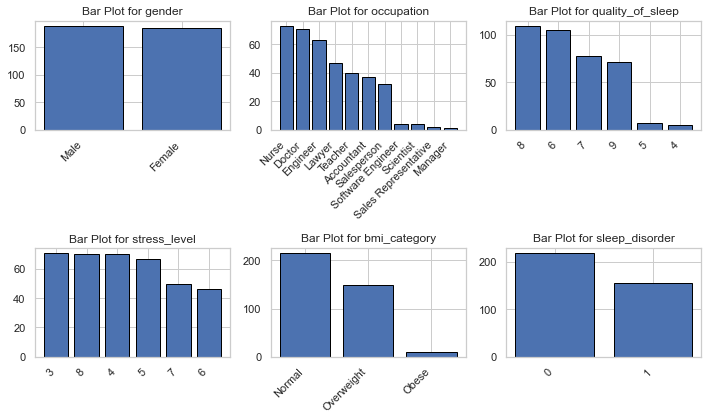

In [64]:
# Barplots for categorical
def pie_bar(data, features):
    n_features = len(features)
    n_cols = 3 
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
    axs = axs.flatten()
    
    for idx, feature in enumerate(features):
        count_values = data[feature].value_counts()
        axs[idx].bar(x=count_values.index, height=count_values.values, edgecolor='black')
        axs[idx].set_xticks(range(len(count_values)))
        axs[idx].set_xticklabels(count_values.index, rotation=45, ha='right')
        axs[idx].set_title(f"Bar Plot for {feature}")
    
    plt.tight_layout()
    plt.show()

pie_bar(data, categorical_variables)


Of the seven numerical variables, all are continuous. Plotting histograms and boxplots side by side, two categories emerge:

- Measured variables
- Estimated/rounded variables (variables that were probably estimated as part of a questionnaire by participants)

For the measured variables, age, heart rate, and sleep duration, a more or less continuous distribution can be identified. Age, while showing variance, still is somewhat uniformly distributed between the limits of around 30 to 60. Sleep duration appears to show three groups: one group having very little sleep (up to 6.5 hours) and one group sleeping for longer times (more than 8 hours), with a dip in sleeping time observed between these two groups. As the last variable of this group, the heart rate is shown to have the majority of its observations between 65 and 75, with visual hints of a normal distribution. However, it shows significant outliers for higher heart rates in both the histogram and boxplot, which will need to be addressed in the preprocessing step.
The estimated/rounded variables (physical activity level, daily steps, blood pressure systolic/diastolic) show a specific characteristic with oscillations between highs and lows, attributed to the way people estimate numeric values in increments, like evaluating physical activity level (mins/day) mostly in increments of 15 minutes (half an hour, 45 minutes, one hour, etc.). The lows in between then show observations with more specific answers like 42 minutes, leading to the somewhat irregular appearance of the histograms. Taking this into account, the physical activity level shows a fairly uniform distribution of observations, while daily steps tend more toward a right-skewed uniform distribution, indicating an overall potentially above-average fit sample of people. The high percentage of medical workers with great walking distances as part of their profession might further contribute to this. Meanwhile, the blood pressure systolic/diastolic appears to be more or less evenly distributed.

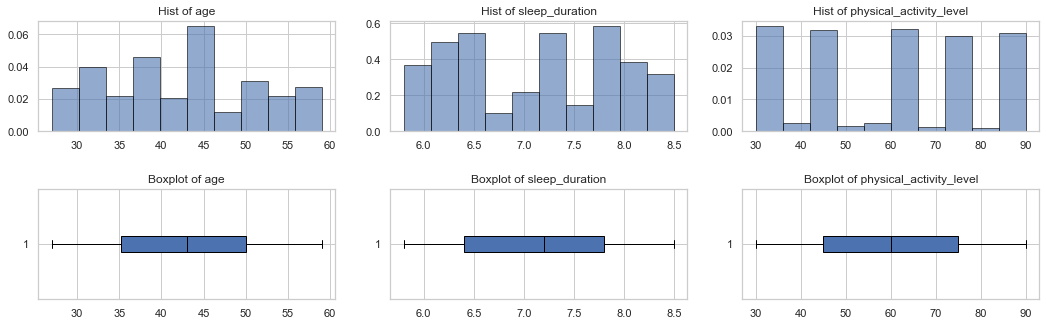

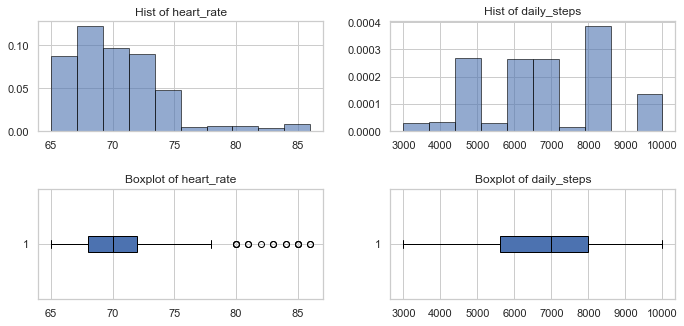

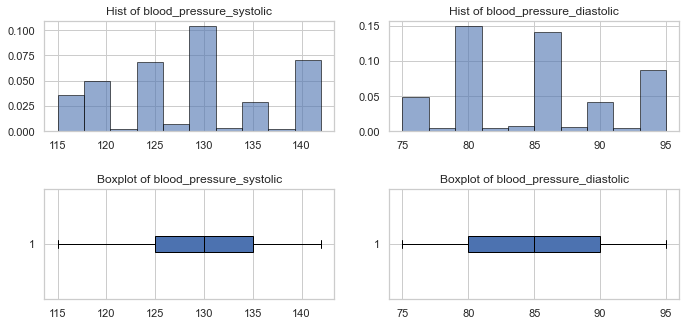

In [65]:
### Histograms + Boxplot
def hist_box_plot(data, numeric_variables):
    fig, axs = plt.subplots(2, len(numeric_variables), figsize=(len(numeric_variables)*5, 5))
    for i, feature in enumerate(numeric_variables):
        
        # Plot histogram
        axs[0, i].hist(data[feature], bins=10, density=True, alpha=0.6, color='b', edgecolor="black")
        axs[0, i].set_title(f"Hist of {feature}")

        # Plot boxplot
        axs[1, i].boxplot(data[feature], vert=False, patch_artist=True, medianprops=dict(color="black"))
        axs[1, i].set_title(f"Boxplot of {feature}")
    
    plt.tight_layout(pad=2.0)

hist_box_plot(data, numeric_variables[0:3])
hist_box_plot(data, numeric_variables[3:5])
hist_box_plot(data, numeric_variables[5:])

As a first attempt to evaluate the correlations found in this dataset, the following set of Metrics is applied and plotted.


\begin{aligned}
q_1 &= \left(1 - \frac{\min \lambda_j}{\max \lambda_j} \right)^{p+2}, & \quad q_4 &= \left(\frac{\max \lambda_j}{p} \right)^{3/2}, \\
q_2 &= 1 - \frac{p}{\sum_{j=1}^p \left(1/\lambda_j\right)}, & \quad q_5 &= \left(1 - \frac{\min \lambda_j}{p} \right)^5, \\
q_3 &= 1 - \sqrt{|R|}, & \quad q_6 &= \sum_{j=1}^p \frac{1 - 1/r_{ij}}{p}.
\end{aligned}



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


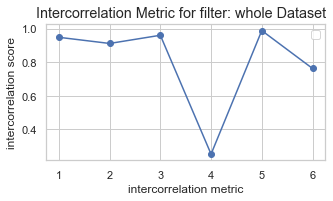

In [66]:
### Statistical Analysis & intercorrelation

means = data[numeric_variables].mean()
variances = data[numeric_variables].var()
df_covariance_matrix = data[numeric_variables].cov()
df_correlation_matrix = data[numeric_variables].corr()

def intercorrelations(X,categorical_filter = "whole Dataset",label = None):
    n, p = X.shape
    R = np.corrcoef(X, rowvar=False)
    lambda_vals, _ = eig(R)
    rjj = np.diag(inv(R))
    q = np.zeros(6)
    q[0] = (1 - min(lambda_vals) / max(lambda_vals)) ** (p + 2)
    q[1] = 1 - p / np.sum(1. / lambda_vals)
    q[2] = 1 - np.sqrt(det(R))
    q[3] = (max(lambda_vals) / p) ** (3 / 2)
    q[4] = (1 - min(lambda_vals) / p) ** 5
    q[5] = np.sum((1 - 1. / rjj) / p)
    
    # plot
    plt.plot(range(1, 7), q, marker='o', linestyle='-', label=label)
    plt.xlabel("intercorrelation metric")
    plt.ylabel("intercorrelation score")
    plt.suptitle("Intercorrelation Metric for filter: "+categorical_filter)
    plt.legend()

    return None

plt.figure(figsize=(5,2.5))
intercorrelations(data[numeric_variables])

Applying the same method to a dataset filtered on the binary variable sleep disorder shows an overall higher than before correlation in the subset with sleep disorder while the subset for people without sleep disorder shows lower correlation metrics than the joined dataset. 

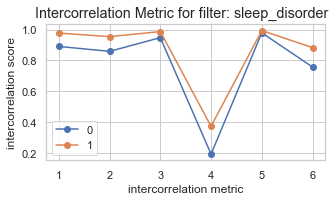

In [67]:
#intercorrelation by category function
def inter_by_category(df,cat):
    count_values = df[cat].value_counts().index
    plt.figure(figsize=(5,2.5))
    for i in count_values:
        aux_data = df[df[cat]==i]
        intercorrelations(aux_data[numeric_variables],categorical_filter=cat,label=i)

inter_by_category(data,'sleep_disorder')

Expanding the correlation analysis with a pair plot shows a variety of potential correlations between variables, the most notable being the linear correlation between blood pressure systolic and diastolic, as well as between daily steps and heart rate/blood pressure. Further correlation can be seen between physical activity level and sleep duration, while the plot of age vs. sleep duration appears to show certain clusters that may be further analyzed in the second part of this work.

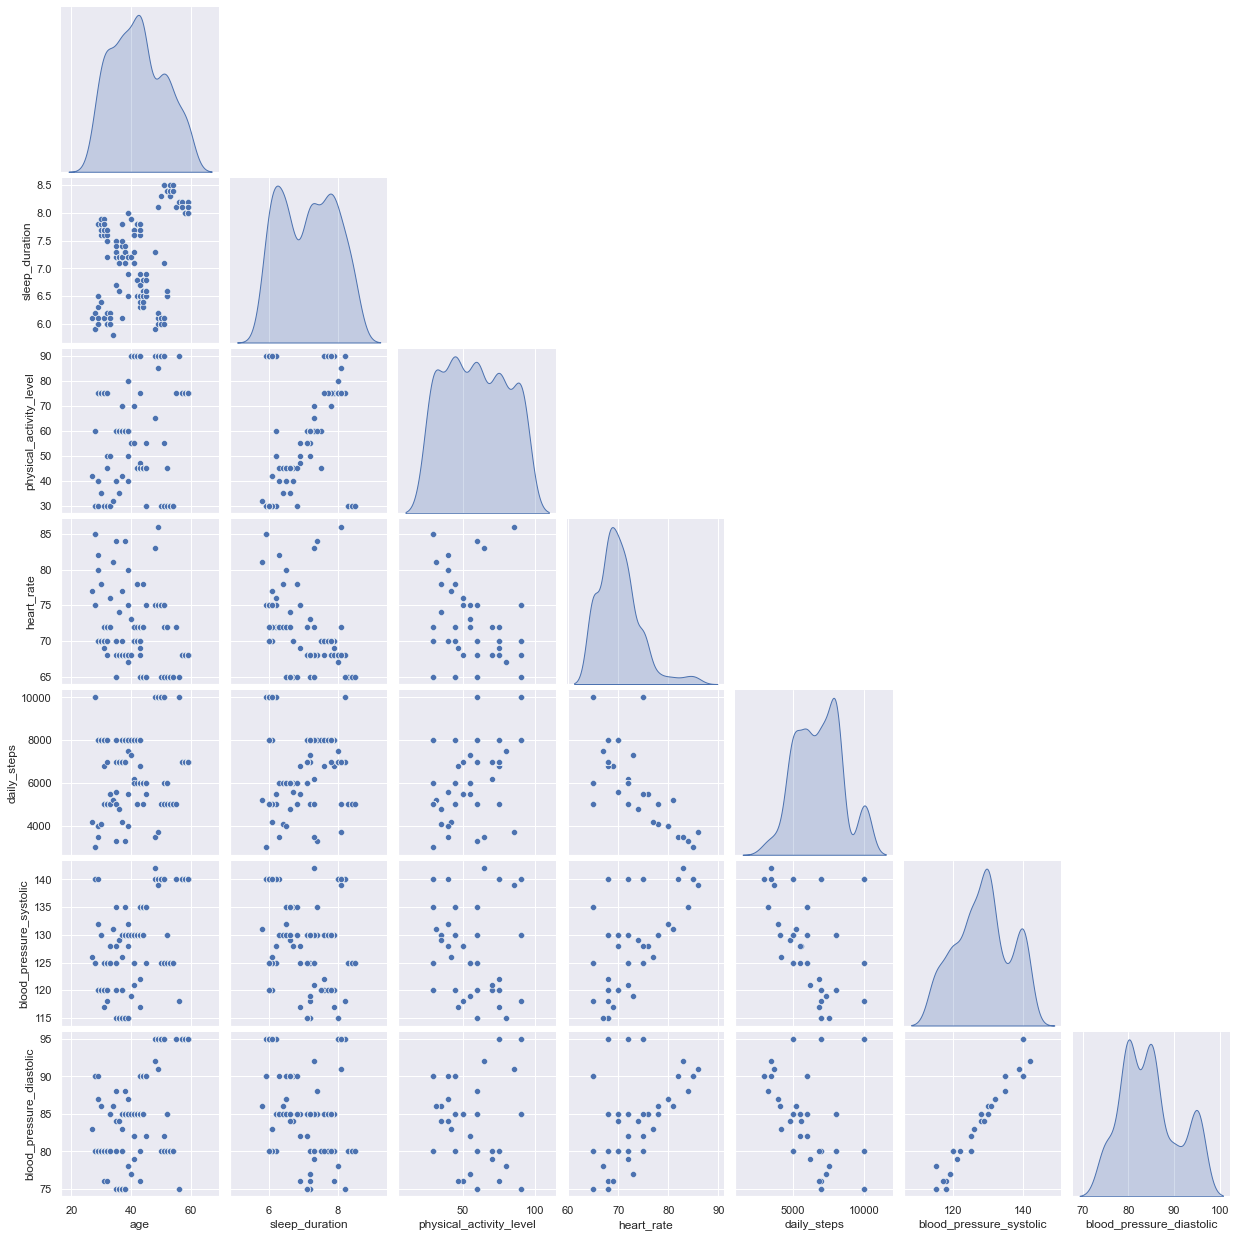

In [68]:
# pairplot
sns.set(rc={'figure.figsize':(6, 3)})
sns.pairplot(data[numeric_variables], diag_kind='kde', corner=True)
plt.show()

Plotting the correlation corresponding matrix reflects some of the observations made in the pairplot, with the verious near 100% correlation between blood pressure systolic and diastolic very aparent. Two previously less apparent correlations are the ones between age and blood pressure as well as the correlation between physical activity and daily steps. 

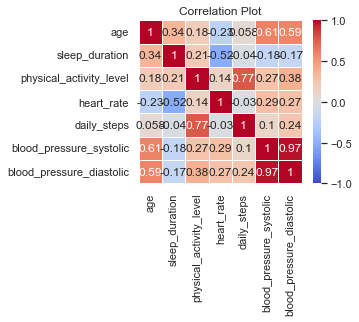

In [69]:
corr_mat = data[numeric_variables].corr()
plt.figure(figsize=(4, 3))  # Adjust the figure size as needed
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

Plotting the covariance matrix however shows an issue with the current format of the data, where daily steps outweighs all other variances due to its scale (3000 - 10000). This issue will be adressed in the next section of part one of this work. 

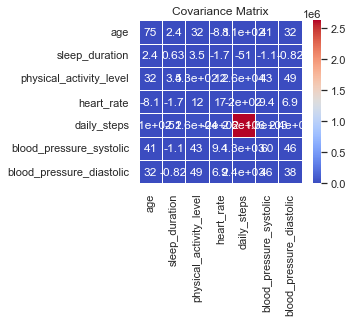

In [70]:
def cov_plot(data,numeric_variables):
    corr_mat = data[numeric_variables].cov()
    plt.figure(figsize=(4, 3))  # Adjust the figure size as needed
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', square=True, linewidths=0.5)
    plt.title('Covariance Matrix')
    plt.show()

cov_plot(data,numeric_variables)

Having a general overview of structure and correlation in the data, the next step is to scaling and outlier issues in the next subsection.

In [71]:
# # Function for plotting of conditional histograms 
# def plot_categorical_hist(data,
#                           ncols,
#                           numeric_variables,
#                           categorical_variables,
#                           host_stat='count',
#                           figsize=(12, 10)
#                           ):
    
#     nrows = math.ceil(len(numeric_variables)/ncols)
#     fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
#     for i, col in enumerate(numeric_variables):
#         row = i // 2 
#         col_pos = i % 2 
#         sns.histplot(data=data, x=col, bins=10,hue=categorical_variables, kde=True, ax=axes[row, col_pos],stat=host_stat)
#         axes[row, col_pos].set_title(f'Distribution of {col}')

#     # Adjust layout for better spacing
#     plt.tight_layout()
#     plt.show()

# # TODO: Select relevant ones 
# for categorical_variable in categorical_variables:
#     print(categorical_variable)
#     plot_categorical_hist(data=data,
#                           ncols=2,
#                           numeric_variables=numeric_variables,
#                           categorical_variables=categorical_variable,
#                           host_stat='probability',
#                           figsize=(12, 20))

### Preprocessing

The following two issues in the current data set: 
- Outliers in variable "heart rate"
- Scaling issue to (among others) variable "daily steps"

This section corrects outliers, validates skewness and standardizes the numeric variables.

### Outliers and Skewness

The aim of this part of the preprocessing, is to obtain symmetric variables without outliers in order to apply in a correct form the PCA. 

It is observed that only one variable has outliers and positive skewness problems (heart rate). Therefore, the first step is to cut the outliers (4% of the dataframe), and then, check if the skewness problem is also corrected.

In [72]:
# print skewness
for i in numeric_variables:
    aux_skew = stats.skew(data[i])
    print(f"Skewness of {i} : {aux_skew}")

Skewness of age : 0.2561893511793312
Skewness of sleep_duration : 0.037403602518975176
Skewness of physical_activity_level : 0.07418782500797434
Skewness of heart_rate : 1.2199056700731632
Skewness of daily_steps : 0.17756151681455
Skewness of blood_pressure_systolic : -0.03552565092220491
Skewness of blood_pressure_diastolic : 0.37705009626387237


In [73]:
summary_stats = []

for i in numeric_variables:
    # Compute the descriptive statistics using scipy.stats.describe
    description = stats.describe(data[i])
    p90 = np.percentile(data[i], 90)
    p95 = np.percentile(data[i], 95)
    p99 = np.percentile(data[i], 99)

    # Store the results as a dictionary (with variable name as key)
    summary_stats.append({
        'Variable': i,
        'Count': description.nobs,
        'Min': description.minmax[0],
        'Mean': description.mean,
        'Percentile 90%': p90,
        'Percentile 95%': p95,
        'Percentile 99%': p99,
        'Max': description.minmax[1],
        'Variance': description.variance
    })

# Convert the list of dictionaries to a DataFrame for easier display
summary_df = pd.DataFrame(summary_stats)

# Display the summary statistics table
#print(summary_df)


In [74]:
for i in numeric_variables:
    q1 = np.percentile(data[i], 25)
    q3 = np.percentile(data[i], 75)
    RIC = q3 - q1 
    nout = np.sum(data[i] > (q3 + 1.5*RIC))
    print(f"The threshold for {i} upper outliers is  {q3 + 1.5*RIC}")
    print(f" then there are {nout} outliers in this variable, representing the {np.round(nout/374*100,2)} % of the dataset")

The threshold for age upper outliers is  72.125
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for sleep_duration upper outliers is  9.899999999999999
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for physical_activity_level upper outliers is  120.0
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for heart_rate upper outliers is  78.0
 then there are 15 outliers in this variable, representing the 4.01 % of the dataset
The threshold for daily_steps upper outliers is  11600.0
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for blood_pressure_systolic upper outliers is  150.0
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for blood_pressure_diastolic upper outliers is  105.0
 then there are 0 outliers in this variable, representing the 0.0 % of

We can see that the skewness was also corrected by cutting the oultiers observations. For that reason, there is not needed another type of transformation.

Skewness of heart_rate : 0.207482395234077


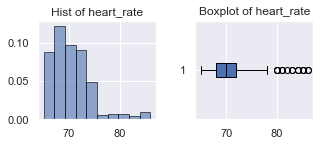

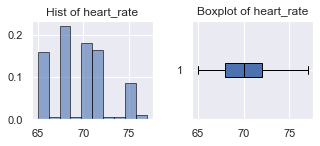

In [75]:
# temporary data while we have all the transformations
data_cut = data[data['heart_rate'] < 78] 

# CHECKING SKEWNESS AFTER CUTTING OUTLIERS
aux_skew = stats.skew(data_cut["heart_rate"])
print(f"Skewness of heart_rate : {aux_skew}")


# TODO: Add x axis label, turn into two big plots

# function for histogram + boxplots on numerical variables
def hist_box_plot_basic(data, feature):
    fig, axs = plt.subplots(1,2, figsize=(5, 2.5))
    axs[0].hist(data[feature],bins=10,density=True,alpha=0.6,color='b',edgecolor="black")
    axs[0].set_title(f"Hist of {feature}")
    axs[1].boxplot(data[feature],vert=False, patch_artist=True,medianprops=dict(color="black"))
    axs[1].set_title(f"Boxplot of {feature}")
    plt.tight_layout(pad=2.0)


# plot hist % boxplot before and after
hist_box_plot_basic(data,"heart_rate")
hist_box_plot_basic(data_cut,"heart_rate")

### Standardize numeric variables

Having seen in the exploratory data analysis that there exists a strong imbalance in scale between numerical variables in the dataset, the dataset is standardized in this step to mean 0 and scaled on its standarddeviation.

In [76]:
# scale
data_standardized_numeric = (data_cut[numeric_variables] - data_cut[numeric_variables].mean()) / data_cut[numeric_variables].std()
data_standardized = pd.concat([data_standardized_numeric,data_cut[categorical_variables]], axis =1)


Comparing the boxplots pre-standardized and post-standardized shows the major impact the rescaling has, where daily steps previously dominated and now an even distribution for all numeric variables can be seen.

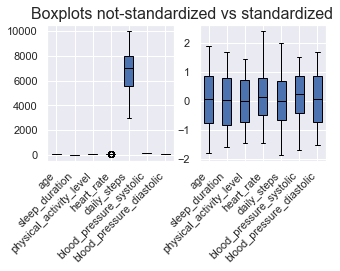

In [77]:
# plot
fig, axs = plt.subplots(1,2, figsize=(5, 2.5))
axs[0].boxplot(data[numeric_variables],vert=True, patch_artist=True,medianprops=dict(color="black"))
axs[0].set_xticklabels(numeric_variables, rotation=45, ha="right")
axs[1].boxplot(data_standardized_numeric[numeric_variables],vert=True, patch_artist=True,medianprops=dict(color="black"))
axs[1].set_xticklabels(numeric_variables, rotation=45, ha="right")
fig.suptitle("Boxplots not-standardized vs standardized", fontsize=16)
print()

As a result from scaling, now the covariance matrix can be constructed, showing similar results compared to the previously analyzed correlation matrix. 

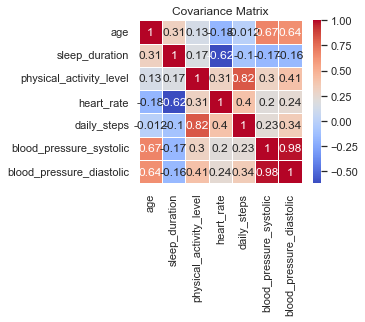

In [78]:
cov_plot(data_standardized,numeric_variables)

### PCA

Having analyzed the data and its characteristic and highly correlated variables identified, as well as having eliminated outliers as well as having standardized the numeric variables, principal component analysis can now be applied in an attempt to reduce dimensionality. 

### Number of Principal Components

By analysing the Explained Variance (eigenvalues) trend, and the Joliffe´s and Kaiser´s criterion, for this project there are selected 3 Principal components that explain the 90\% of the variability.

In [79]:
data_pca = data_standardized[numeric_variables]
#data_pca.to_csv('C:/Users/Usuario/Desktop/UC3M/SC2/MULTIVARIADO/PROYECTO/data_estandarizada.csv', index=False)
pca = PCA()
pca.fit(data_pca)
print()

In [80]:
eig_val = pca.explained_variance_
#print("Explained Variance: ", eig_val)

sv = pca.singular_values_
#print("Singular Values: ", sv)

#----------------------- JUST CHECKING MATHS -----------------------
singular_values_squared = sv ** 2
# Compare singular values squared vs eigenvalues
#normalized_singular_values_squared = singular_values_squared / (X_scaled.shape[0] - 1)
#print("Eigenvalues (Explained Variance):", eig_val)
#print("Singular Values Squared (Normalized):", normalized_singular_values_squared)
#--------------------------------------------------------------------------------

# Covariance Matrix
S = np.cov(data_pca, rowvar=False)
print("trace: ", S.trace())

# Kaiser´s criterion
mean_eig = S.trace()/7

# Jollife´s criterion
joliffe = 0.7 * S.trace()/7



trace:  7.0


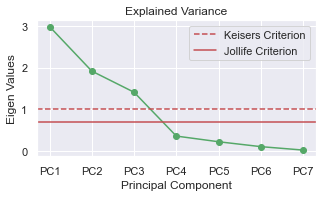

In [81]:

plt.figure(figsize=(5, 2.5))
plt.plot(eig_val, marker = 'o', linestyle = '-', color = 'g')
plt.axhline(y=mean_eig, color='r', linestyle='--', label='Keisers Criterion')
plt.axhline(y=joliffe, color='r', linestyle='-', label='Jollife Criterion')
plt.title("Explained Variance")
plt.xlabel("Principal Component")
plt.ylabel("Eigen Values")

# Change xlabels
tick_positions = [0, 1, 2, 3, 4, 5, 6]
custom_labels = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']  

# Set custom x-ticks with custom labels
plt.xticks(ticks=tick_positions, labels=custom_labels)

plt.legend()
plt.grid(True)
plt.show()

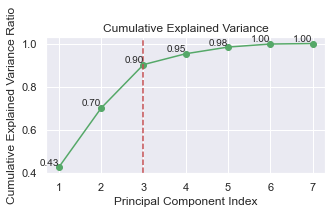

In [82]:

# I AM STILL CHECKING THIS ONE, ONLY TRUST 100% THE ONE THAT IS ABOVE


# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Show the cumulative explained variance
plt.figure(figsize=(5, 2.5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='g')
plt.axvline(x=3, color='r', linestyle='--', label='')
plt.title("Cumulative Explained Variance")
plt.xlabel("Principal Component Index")
plt.ylabel("Cumulative Explained Variance Ratio")

# Adding labels next to the points
for i, (x, y) in enumerate(zip(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)):
    plt.text(x, y, f'{y:.2f}', horizontalalignment='right', verticalalignment='bottom', fontsize=10)

plt.grid(True)
plt.show()


In [83]:
# calc delta variance
delta_explained_variance  = []
i = 0
while i < len(cumulative_explained_variance)-1:
    delta_explained_variance.append(cumulative_explained_variance[i+1]-cumulative_explained_variance[i])
    i = i+1
delta_explained_variance.insert(0, cumulative_explained_variance[0])

|    **Value**      |  **PC1**   |  **PC2**   |  **PC3**  |  **PC4**   |  **PC5**   |  **PC6**   |  **PC7**  |
|-------------------|------------|------------|-----------|------------|------------|------------|-----------|
| **Eigen Values**  | 2.98968 | 1.91745 | 1.40832 | 0.35319 | 0.21651 | 0.09865 | 0.01619 |
| **% Variability** | 42.7097 | 27.3922 | 20.1188 | 5.04559 | 3.09299 | 1.40933 | 0.23132 |
| **Cum. Variance** | 42.7097 | 70.1019 | 90.2207 | 95.2663 | 98.3593 | 99.7686 | 100.000 |


In [84]:
# generate transformed Data Set
pca_transformed = pca.transform(data_pca)
df_pca_transformed =pd.DataFrame(pca_transformed,columns=["PC1","PC2","PC3","PC4","PC5","PC6","PC7"])
df_pca_merged = pd.concat([df_pca_transformed, data_cut[categorical_variables].reset_index()],axis=1)


### Contribution of Variables to Principal Components and Interpretation

Plotting the Composition of the Principal Components as a Barplot shows a general overlap in the contribution of all variables to the new found principle components, making a very clear seperation into characteristics that are described by the prinicipal components a more dificult task. Since all outliers and scale differences have been treated in the preprocessing steps, the dataset simply seems not to have directly obvious meaningfull interpretation of its principal components. While interpreability in more general terms is one of the challenges associated to PCA, an attempt is made to give some intuition to the three principal component dimensions selected to represent this data set. The first principal component PC1 can be interpreted as overall characteristics of a person, with all variables except for sleep_duration somewhat evenly related. PC2 could be interpreted as the dimension of age, with age, leep duration and heart rate mainly contributing. Simelarly, PC3 could be interpreted as the physical condition dimension, with physical activity level, daily steps and sleep duration primarily contributing.

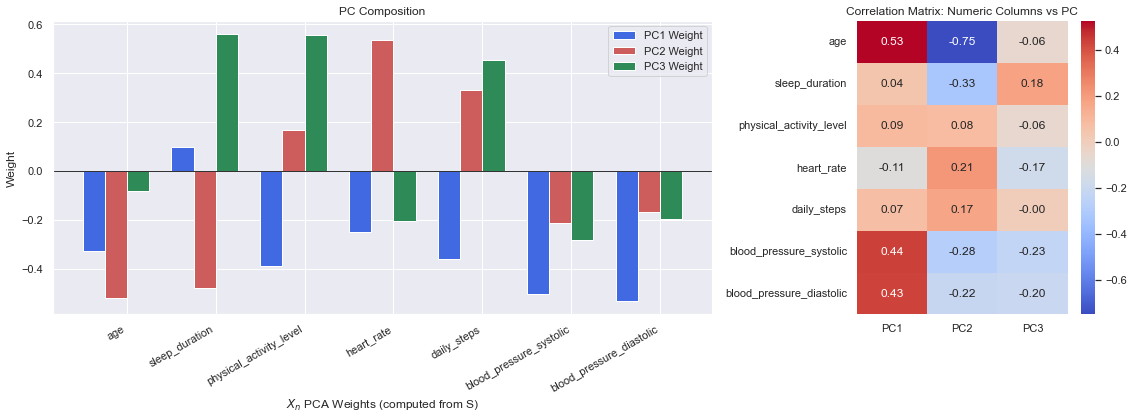

In [85]:
def eigsort(S):
    # Eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eig(S)
    # Sort Eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    Lambda = sorted_eigenvalues
    
    return sorted_eigenvectors, Lambda

def contribution_plot(ax, arrays, colors, labels, x_labels, width=0.2):
    n_arrays = len(arrays)
    x_indices = np.arange(len(arrays[0])) + 1

    # Barplots
    for i, (array, color, label) in enumerate(zip(arrays, colors, labels)):
        bar_positions = x_indices + (i - n_arrays / 2) * width
        ax.bar(bar_positions, array, width=width, color=color, label=label)

    # Cosmetics
    ax.set_xlabel("$X_n$ PCA Weights (computed from S)")
    ax.set_ylabel("Weight")
    ax.set_title("PC Composition")
    ax.axhline(0, color='black', linewidth=0.8, linestyle='-') 
    ax.set_xticks(x_indices)
    ax.set_xticklabels(x_labels, rotation=30, ha="right")
    ax.legend()

[T, Lambda] = eigsort(S)

# Correlation Matrix
correlation_matrix = pd.DataFrame(
    {col2: [data_pca[col1].corr(df_pca_merged[col2]) for col1 in numeric_variables] for col2 in ["PC1","PC2","PC3"]},
    index=data_pca.columns
)

# Create Figure
fig, axs = plt.subplots(1, 2, figsize=(16, 6),gridspec_kw={'width_ratios': [2.5, 1]})

# Brplot (Contribution)
contribution_plot(
    ax=axs[0],
    arrays=[T[:, 0], T[:, 1], T[:, 2]],
    colors=["royalblue", "indianred", "seagreen"],
    labels=["PC1 Weight", "PC2 Weight", "PC3 Weight"],
    x_labels=numeric_variables,
    width=0.25
)

# Correlation Plot
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, ax=axs[1])
axs[1].set_title("Correlation Matrix: Numeric Columns vs PC")

plt.tight_layout()
plt.show()


Plotting the data transformed into the three first principal components shows a similarly entangled image image as already shown in the barplots, with no obious interpretation. 

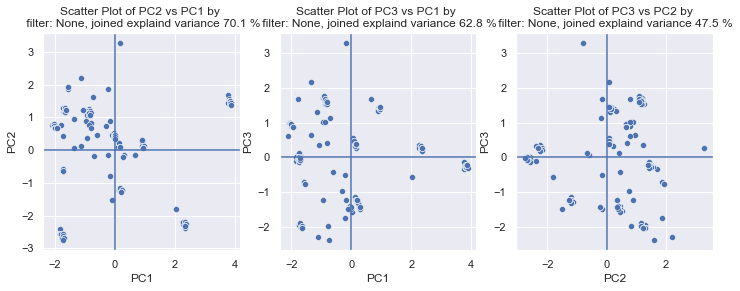

In [86]:

def scatterplot_pc(df, x_col, y_col, hue_col=None, ax=None, expl_var=None):
    # plot
    sns.scatterplot(data=df, 
                    x=x_col, 
                    y=y_col, 
                    hue=hue_col,
                    palette='Set1',
                    ax=ax)
    
    # cosmetics
    ax.set_title(f'Scatter Plot of {y_col} vs {x_col} by \n filter: {hue_col}, joined explaind variance {expl_var} %')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.axhline(0)
    ax.axvline(0)


fig, axs = plt.subplots(1, 3, figsize=(12, 4))
scatterplot_pc(df_pca_merged,x_col="PC1",y_col = "PC2", ax = axs[0],expl_var = round(delta_explained_variance[0]+delta_explained_variance[1],3)*100)
scatterplot_pc(df_pca_merged,x_col="PC1",y_col = "PC3", ax = axs[1],expl_var = round(delta_explained_variance[0]+delta_explained_variance[2],3)*100)
scatterplot_pc(df_pca_merged,x_col="PC2",y_col = "PC3", ax = axs[2],expl_var = round(delta_explained_variance[1]+delta_explained_variance[2],3)*100)
plt.show()


By plotting the 3 principal planes obtained labeled with the categorical variables, interesting relations were found. This relations could help us to give names to each PC.

- **PC1 (Wellness):** Can be interpreted as a person wellness because it makes a good separation between having or not a sleep disorder and also of having or not overweight.

- **PC2 (Stress Level):** Higher values of the PC2 indicates higher stress levels (The stress level is well organized in this component). Also, positive values of this component are related with a greater age and having high pressure, while lower values are related with a more active life.

- **PC3 (Physical Activity):** In this component a relation is less clear  with any of the categorical variables, so the interpretation from the continous variables contribution is mantained as the PC name.

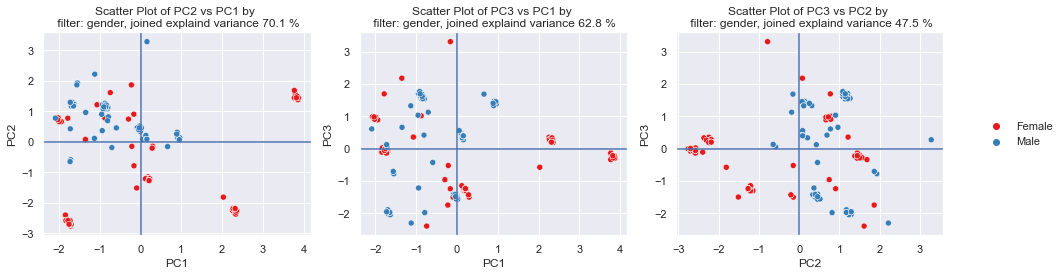

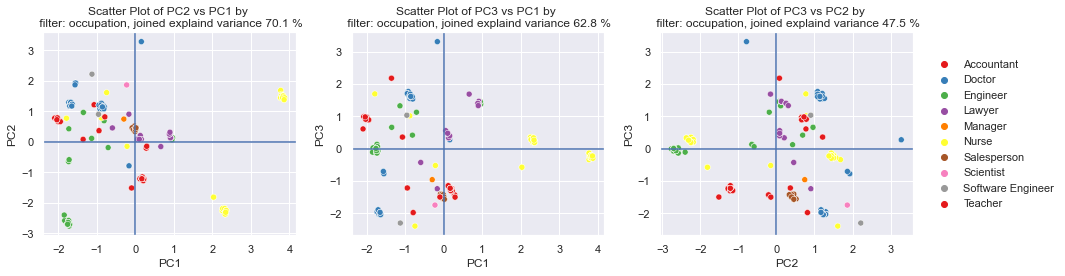

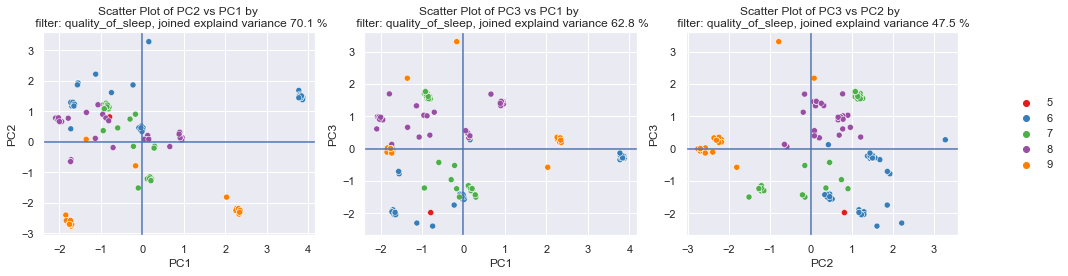

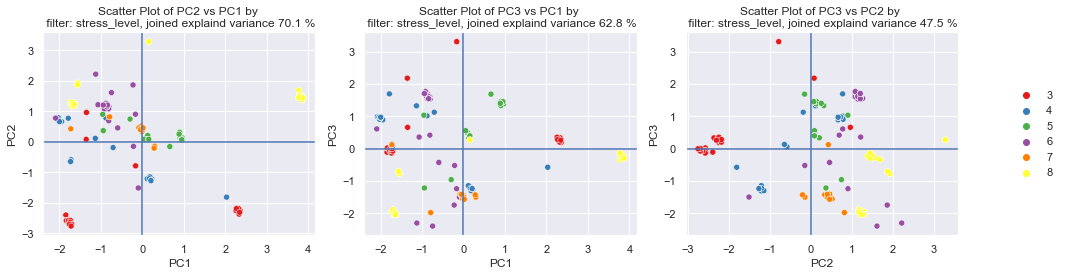

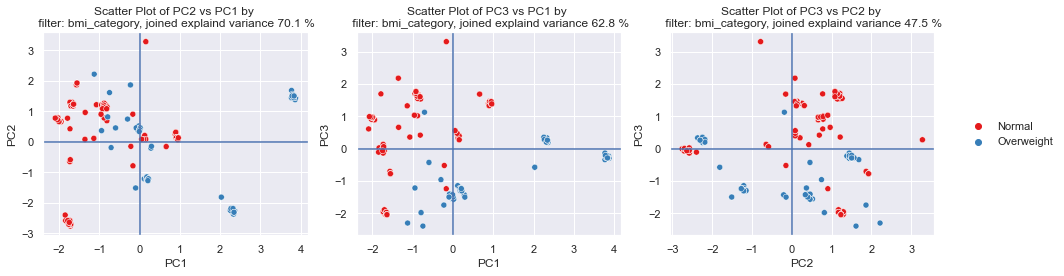

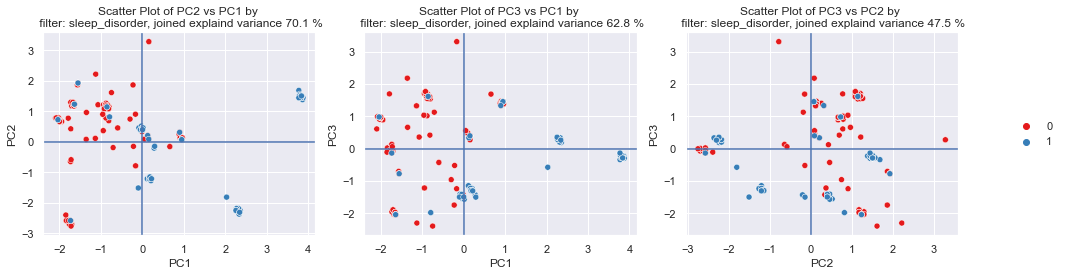

In [87]:
for categorical_variable in categorical_variables:
    fig, axs = plt.subplots(1, 4, figsize=(15, 4), gridspec_kw={'width_ratios': [1, 1, 1, 0.2]})
    
    # Create the scatter plots
    scatter1 = scatterplot_pc(
        df_pca_merged.sort_values(by=[categorical_variable]),
        x_col="PC1",
        y_col="PC2",
        hue_col=categorical_variable,
        ax=axs[0],
        expl_var=round(delta_explained_variance[0] + delta_explained_variance[1], 3)*100
    )
    axs[0].legend().set_visible(False)

    
    scatterplot_pc(
        df_pca_merged.sort_values(by=[categorical_variable]),
        x_col="PC1",
        y_col="PC3",
        hue_col=categorical_variable,
        ax=axs[1],
        expl_var=round(delta_explained_variance[0] + delta_explained_variance[2], 3)*100
    )
    axs[1].legend().set_visible(False) 

    
    scatterplot_pc(
        df_pca_merged.sort_values(by=[categorical_variable]),
        x_col="PC2",
        y_col="PC3",
        hue_col=categorical_variable,
        ax=axs[2],
        expl_var=round(delta_explained_variance[1] + delta_explained_variance[2], 3)*100
    )
    axs[2].legend().set_visible(False)

    
    # Add Manual Legend to side
    handles, labels = axs[0].get_legend_handles_labels()
    axs[3].legend(handles=handles, labels=labels, loc='center', frameon=False)
    axs[3].axis('off') 

    # plot
    plt.tight_layout()
    plt.show()


A first glance at possible meaning behind the principal components is only found when plotting the transformed data in three dimensions with a colorcoding for the categorical features. Doing so, first patterns emerge. Some observable pattern include: 
- male data points being closer to the origin and female values data points
- clusters of occupations visible, sometimes in combination with stress level like two clusters for nurses, one with low and one with high stress level

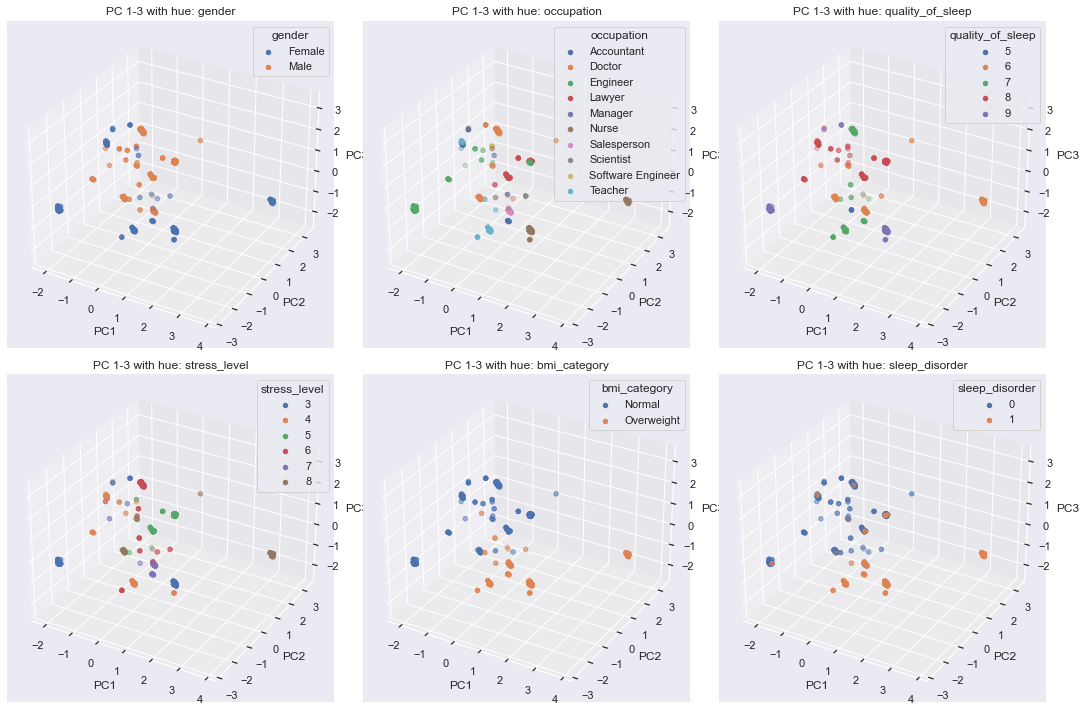

In [88]:
def scatterplot_3d(ax, df, x_col, y_col, z_col, hue_col):
    
    unique_hues = df[hue_col].unique()
    for hue in unique_hues:
        hue_df = df[df[hue_col] == hue]
        ax.scatter(hue_df[x_col], hue_df[y_col], hue_df[z_col], label=hue)

    # cosmetics
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col)
    ax.set_title(f'PC 1-3 with hue: {hue_col}')
    ax.legend(title=hue_col)

def scatterplot_3d_subplots(df, categorical_variables, x_col, y_col, z_col):
    
    n_cols = 3
    n_rows = (len(categorical_variables) + 1) // n_cols
    fig = plt.figure(figsize=(15,10))

    # make subplots    
    for i, categorical_variable in enumerate(categorical_variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1, projection='3d')
        scatterplot_3d(ax, df.sort_values(by=[categorical_variable]), x_col, y_col, z_col, categorical_variable)
    
    # cosmetics
    plt.tight_layout()
    plt.show()


# Call the function to create subplots
scatterplot_3d_subplots(df_pca_merged, categorical_variables, x_col="PC1", y_col="PC2", z_col="PC3")


These emerging patterns between the principal components, the numerical and categorical variables and more specifically sleep disorder show an apparent clustering potential that can be further investigated in the second part of this project via distance based metrics. 

### Stability of the Principal components

In [89]:
def PCAcovstability(X):
    #create H matrix to do covariance for pca
    n, p = X.shape
    H = np.eye(n) - np.ones((n, n)) / n
    X = np.dot(H, X)
    S = np.cov(X, rowvar=False, bias=True) 
    
    T, D = eigsort(S)
    Y = np.dot(X, T) 
    
    for j in range(p):
        if T[0, j] < 0:
            T[:, j] = -T[:, j]
    
    v = np.zeros((n, n))
    for i in range(n):
        Xi = np.delete(X, i, axis=0)  
        Si = np.cov(Xi, rowvar=False, bias=True)
        Ti, Di = eigsort(Si)
        
        for j in range(p):
            if Ti[0, j] < 0:
                Ti[:, j] = -Ti[:, j]
        
        Yi = np.dot(Xi, Ti)
        y = X[i, :] @ Ti 
        
        Yplusi = np.vstack([Yi[:i, :], y, Yi[i:, :]])
        
       #calculate euclidean distances 
        for k in range(n):
            v[k, i] = np.linalg.norm(Yplusi[k, :] - Y[k, :])
    
    v = np.sqrt(v) 
    #save summarize values in table to analysis
    Rad = np.zeros((n, 6))
    for i in range(n):
        Rad[i, 0] = np.min(v[i, :])
        Rad[i, 1] = np.max(v[i, :])
        Rad[i, 2] = np.quantile(v[i, :], 0.50)
        Rad[i, 3] = np.quantile(v[i, :], 0.75)
        Rad[i, 4] = np.quantile(v[i, :], 0.90)
        Rad[i, 5] = np.quantile(v[i, :], 0.95)
    
    rowsummary = np.vstack([np.mean(Rad, axis=0), np.std(Rad, axis=0), np.median(Rad, axis=0), np.median(np.abs(Rad - np.median(Rad, axis=0)), axis=0)])
    
    stats_labels = ['Mean', 'Standard Deviation', 'Median', 'Mean Absolute Deviation (MAD)']
    pca_labels = ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4', 'PCA 5', 'PCA 6']
    
    rowsummary_df = pd.DataFrame(rowsummary.T, columns=stats_labels, index=pca_labels)
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 5))

    # Boxplot
    axes[0].boxplot(v)
    axes[0].set_title('Euclidean distance of each unit among configurations')

    # Barplot
    euclidean_distances = np.mean(v, axis=1)
    axes[1].bar(range(1, n + 1), euclidean_distances, color='orange', alpha=0.7)
    axes[1].set_xlabel('Observation Index')
    axes[1].set_ylabel('Euclidean Distance')
    axes[1].set_title('PCA Configuration Stability')
    axes[1].grid()

    # Show the plot
    plt.tight_layout()  # Adjust spacing
    plt.show()  
         
    return rowsummary_df


To perform the stability analysis using the leave-one-out method, we obtained 354 different outputs, which makes it challenging to interpret the results visually. Even though you can see that the values are very consistence across both graph.

The values in the table are quite consistent across the different PCAs, indicating that they all exhibit similar average Euclidean distances and very low standard deviations. This suggests that the principal components are stable, remaining unaffected by changes in the data. Consequently, this implies that the PCA captures the underlying structure of the data reliably, providing confidence in the robustness of the results. In general, this suggests that the PCA model is likely to generalize well to new data.

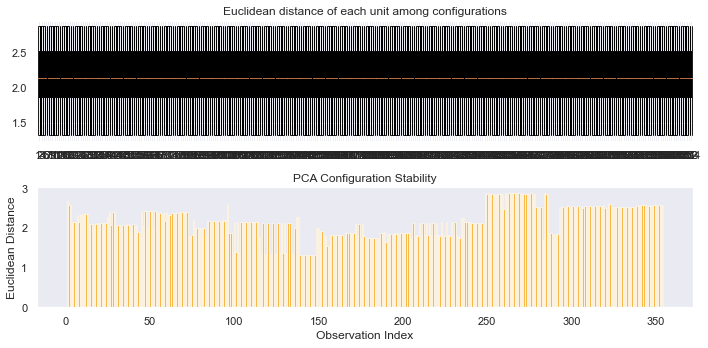

,Mean,Standard Deviation,Median,Mean Absolute Deviation (MAD)
PCA 1,2.169042,0.396796,2.139104,0.306660
PCA 2,2.170711,0.396445,2.140058,0.305647
PCA 3,2.169899,0.396737,2.139598,0.306719
PCA 4,2.169952,0.396728,2.139642,0.306678
PCA 5,2.170067,0.396691,2.139747,0.306680
PCA 6,2.170119,0.396667,2.139757,0.306644


In [90]:
PCAcovstability(data_standardized_numeric)

### Conclusion Part 1
 
In the first Part of this project work, an exploratory data analysis has been performed in support of a principal component analysis. The principal component analysis has been shown to deliver three principal components that explain the datas variance well and are stable when genaralizing to new data, while attributing intuitive characteristics to the new dimensions has shown to be challanging. Only when visualizing the categorical variables together with the data in the new dimensions, patterns and cluster emerge. To further understand the in this analysis discovered patterns will be the task of the second part of this work.

# Part 2: Multidimensional Scaling (MDS) and Clustering

In [91]:
# Distance Matrix: mahalanobis

import numpy as np
from scipy.spatial.distance import mahalanobis

def maha_dist(data,numeric_variables):
    data_numeric = data[numeric_variables]

    # Step 1: Compute the covariance matrix and its inverse
    cov_matrix = np.cov(data_numeric.T)  # Transpose because rows are observations
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Step 2: Create an empty distance matrix
    n = len(data_numeric)
    m_distance_mahalanobis = np.zeros((n, n))

    # Step 3: Compute pairwise Mahalanobis distances
    for i in range(n):
        for j in range(n):
            xi = data_numeric.iloc[i].values
            xj = data_numeric.iloc[j].values
            m_distance_mahalanobis[i, j] = mahalanobis(xi, xj, inv_cov_matrix)

    # Step 4: Convert distance matrix to a DataFrame for better readability
    df_distance_mahalanobis = pd.DataFrame(m_distance_mahalanobis, index=data_numeric.index, columns=data_numeric.index)
    return (m_distance_mahalanobis)

In [92]:
maha_dist(data_standardized_numeric, numeric_variables)

array([[0.        , 7.49271331, 7.49271331, ..., 5.43805495, 5.43805495,
        5.43805495],
       [7.49271331, 0.        , 0.        , ..., 6.6890876 , 6.6890876 ,
        6.6890876 ],
       [7.49271331, 0.        , 0.        , ..., 6.6890876 , 6.6890876 ,
        6.6890876 ],
       ...,
       [5.43805495, 6.6890876 , 6.6890876 , ..., 0.        , 0.        ,
        0.        ],
       [5.43805495, 6.6890876 , 6.6890876 , ..., 0.        , 0.        ,
        0.        ],
       [5.43805495, 6.6890876 , 6.6890876 , ..., 0.        , 0.        ,
        0.        ]])

In [93]:
#import gower

# Compute Gower similarity between rows
similarity_matrix = gower.gower_matrix(data)
m_distance_gowers = 1 - similarity_matrix
df_distance_gowers = pd.DataFrame(m_distance_gowers, index=data.index, columns=data.index)
df_distance_gowers

,0,1,2,3,4,5,6,7,8,9,...,364,365,366,367,368,369,370,371,372,373
0,1.000000,0.634546,0.634367,0.484382,0.484204,0.550691,0.573826,0.566046,0.565867,0.565689,...,0.254889,0.254710,0.252062,0.254353,0.251705,0.251526,0.253817,0.251169,0.250990,0.250811
1,0.634546,1.000000,0.999821,0.456785,0.456607,0.456428,0.484501,0.693405,0.693226,0.693048,...,0.204929,0.204750,0.202102,0.204393,0.201745,0.201566,0.203856,0.201209,0.201030,0.200851
2,0.634367,0.999821,1.000000,0.456964,0.456785,0.456607,0.484680,0.693584,0.693405,0.693226,...,0.205108,0.204929,0.202281,0.204571,0.201923,0.201745,0.204035,0.201387,0.201209,0.201030
3,0.484382,0.456785,0.456964,1.000000,0.999821,0.932976,0.762107,0.322334,0.322155,0.321977,...,0.260313,0.260134,0.257486,0.259777,0.257129,0.256950,0.259240,0.256593,0.256414,0.256235
4,0.484204,0.456607,0.456785,0.999821,1.000000,0.933155,0.762286,0.322513,0.322334,0.322155,...,0.260491,0.260313,0.257665,0.259955,0.257307,0.257129,0.259419,0.256771,0.256593,0.256414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,0.251526,0.201566,0.201745,0.256950,0.257129,0.257307,0.294843,0.283470,0.283648,0.283827,...,0.996637,0.996816,0.999464,0.997173,0.999821,1.000000,0.997352,0.999643,0.999464,0.999285
370,0.253817,0.203856,0.204035,0.259240,0.259419,0.259598,0.297133,0.285760,0.285939,0.286117,...,0.998928,0.999106,0.996816,0.999464,0.997173,0.997352,1.000000,0.997352,0.997173,0.996995
371,0.251169,0.201209,0.201387,0.256593,0.256771,0.256950,0.294485,0.283112,0.283291,0.283470,...,0.996280,0.996458,0.999106,0.996816,0.999464,0.999643,0.997352,1.000000,0.999821,0.999643
372,0.250990,0.201030,0.201209,0.256414,0.256593,0.256771,0.294307,0.282933,0.283112,0.283291,...,0.996101,0.996280,0.998928,0.996637,0.999285,0.999464,0.997173,0.999821,1.000000,0.999821


## Multidimensional Scaling

- Distance Matrix -> distance measure
- pot force to fullfill euclidean property -> slides 5
- principal coordinates -> slide 6
- check euclidian property !!!
opt: 
- compare MDS configurations - split in groups (male/female) -> only when fulfilling equal geometric variability -> slide 10
- correlations: original variables vs first n principal coordinates heatmap
- group individuals via mds scatterplot with categorical colorcoding
- Gowers interpolation formula - > mds stability & variables partial influence on principal coordinates

- Interpretation of principal coordinates

## Usual K-means
 - Non-hierarchical
 - Minimize the WCSS (within-clusters sum of squeares)
 - Euclidean distance only for uncorrelated numerical variables.

 ### selection of number of clusters
 - Average silhouette
     Calulates the ratio between the difference in the distance of the selected group and the closest group and the max of the two of them.
     Near 1 is correctly classified, near to -1 should have been clasified in the neighborhood cluster. Near to 0, any of them.
     The greater the average silhouette the better the global quality of the clustering.
 - Elbow method 
     For large datasets. 

### PCA

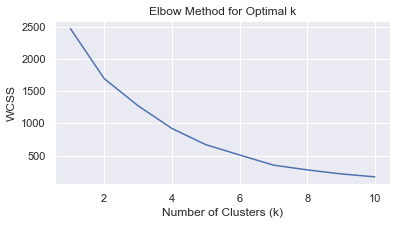

In [94]:
from sklearn.cluster import KMeans

X_pca = pca.fit_transform(data_pca)

# Elbow Method
wcss = []
for k in range(1, 11):  # Try k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS

# Plotting the Elbow Graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# 2, 5 or 7 clusters

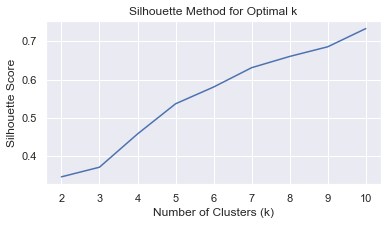

In [95]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):  # Silhouette score is undefined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    score = silhouette_score(X_pca, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting the Silhouette Scores
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


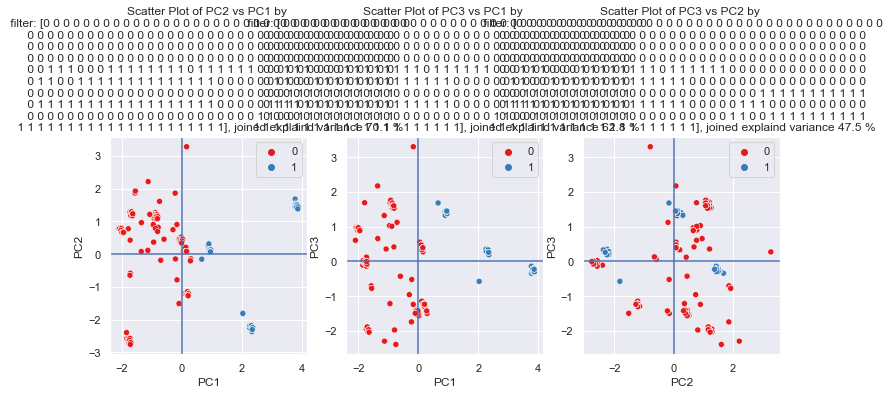

Inertia (WCSS): 1694.061747451845
Silhouette Score: 0.3464442727838054


In [96]:
# Step 2: Perform K-Means clustering on the reduced data
kmeans = KMeans(n_clusters=2, random_state=14, init="random", n_init=30)
kmeans.fit(X_pca)

# Get the cluster labels
labels = kmeans.labels_

# Step 3: Visualize the results
#cmap='viridis'

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
scatterplot_pc(df_pca_merged,x_col="PC1",y_col = "PC2", hue_col=labels,
                ax = axs[0],expl_var = round(delta_explained_variance[0]+delta_explained_variance[1],3)*100)
scatterplot_pc(df_pca_merged,x_col="PC1",y_col = "PC3", hue_col=labels,
                ax = axs[1],expl_var = round(delta_explained_variance[0]+delta_explained_variance[2],3)*100)
scatterplot_pc(df_pca_merged,x_col="PC2",y_col = "PC3", hue_col=labels,
                ax = axs[2],expl_var = round(delta_explained_variance[1]+delta_explained_variance[2],3)*100)
plt.show()

# CHECKING THE CLUSTERS
# Get the inertia (WCSS)
inertia = kmeans.inertia_
print(f"Inertia (WCSS): {inertia}")

from sklearn.metrics import silhouette_score

# Assuming kmeans.labels_ contains the cluster labels
sil_score = silhouette_score(X_pca, kmeans.labels_)
print(f"Silhouette Score: {sil_score}")


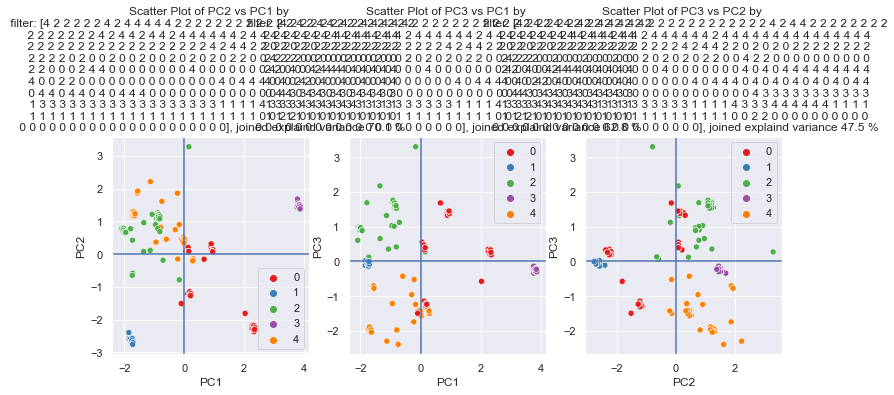

Inertia (WCSS): 705.8868031341824
Silhouette Score: 0.5049929992041031


In [97]:
# Step 2: Perform K-Means clustering on the reduced data
kmeans5 = KMeans(n_clusters=5, random_state=14, init="random", n_init=30)
kmeans5.fit(X_pca)

# Get the cluster labels
labels = kmeans5.labels_

# Step 3: Visualize the results

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
scatterplot_pc(df_pca_merged,x_col="PC1",y_col = "PC2", hue_col=labels,
                ax = axs[0],expl_var = round(delta_explained_variance[0]+delta_explained_variance[1],3)*100)
scatterplot_pc(df_pca_merged,x_col="PC1",y_col = "PC3", hue_col=labels,
                ax = axs[1],expl_var = round(delta_explained_variance[0]+delta_explained_variance[2],3)*100)
scatterplot_pc(df_pca_merged,x_col="PC2",y_col = "PC3", hue_col=labels,
                ax = axs[2],expl_var = round(delta_explained_variance[1]+delta_explained_variance[2],3)*100)
plt.show()

# Get the inertia (WCSS)
inertia5 = kmeans5.inertia_
print(f"Inertia (WCSS): {inertia5}")

# Assuming kmeans.labels_ contains the cluster labels
sil_score = silhouette_score(X_pca, kmeans5.labels_)
print(f"Silhouette Score: {sil_score}")

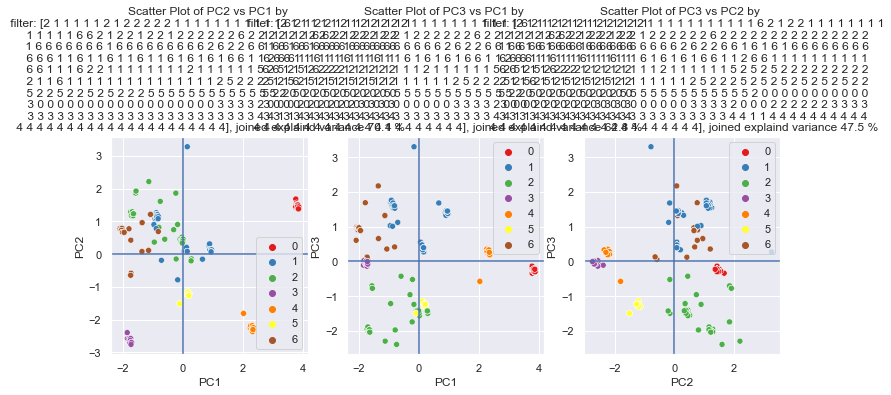

Inertia (WCSS): 375.4857070573261
Silhouette Score: 0.5973103023890334


In [98]:
# Step 2: Perform K-Means clustering on the reduced data
kmeans7 = KMeans(n_clusters=7, random_state=14, init="random", n_init=30)
kmeans7.fit(X_pca)

# Get the cluster labels
labels = kmeans7.labels_

# Step 3: Visualize the results

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
scatterplot_pc(df_pca_merged,x_col="PC1",y_col = "PC2", hue_col=labels,
                ax = axs[0],expl_var = round(delta_explained_variance[0]+delta_explained_variance[1],3)*100)
scatterplot_pc(df_pca_merged,x_col="PC1",y_col = "PC3", hue_col=labels,
                ax = axs[1],expl_var = round(delta_explained_variance[0]+delta_explained_variance[2],3)*100)
scatterplot_pc(df_pca_merged,x_col="PC2",y_col = "PC3", hue_col=labels,
                ax = axs[2],expl_var = round(delta_explained_variance[1]+delta_explained_variance[2],3)*100)
plt.show()

# Get the inertia (WCSS)
inertia7 = kmeans7.inertia_
print(f"Inertia (WCSS): {inertia7}")

# Assuming kmeans.labels_ contains the cluster labels
sil_score = silhouette_score(X_pca, kmeans7.labels_)
print(f"Silhouette Score: {sil_score}")

### Original Data

In [99]:
data_pca["pulse_pressure"] = data_pca['blood_pressure_systolic']-data_pca['blood_pressure_diastolic']
data_kmeans = data_pca.drop(['blood_pressure_diastolic', 'blood_pressure_systolic'], axis=1)
data_kmeans.head()

,age,sleep_duration,physical_activity_level,heart_rate,daily_steps,pulse_pressure
0,-1.797986,-1.331241,-0.857921,2.419234,-1.854332,-0.050471
1,-1.681966,-1.205270,0.006648,1.773131,2.016463,0.300034
2,-1.681966,-1.205270,0.006648,1.773131,2.016463,0.300034
7,-1.565946,0.810274,0.727123,0.157875,0.681706,-0.346681
8,-1.565946,0.810274,0.727123,0.157875,0.681706,-0.346681


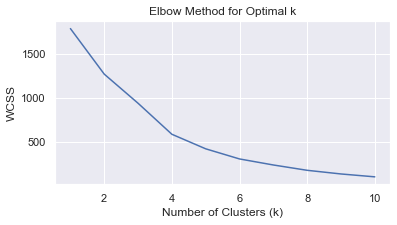

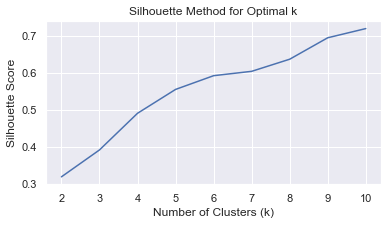

In [100]:
# Elbow Method
wcss = []
for k in range(1, 11):  # Try k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_kmeans)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS

# Plotting the Elbow Graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# 2, 5 or 7 cluster
#_---------------------------------------------------------------------

silhouette_scores = []
for k in range(2, 11):  # Silhouette score is undefined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_kmeans)
    score = silhouette_score(data_kmeans, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting the Silhouette Scores
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

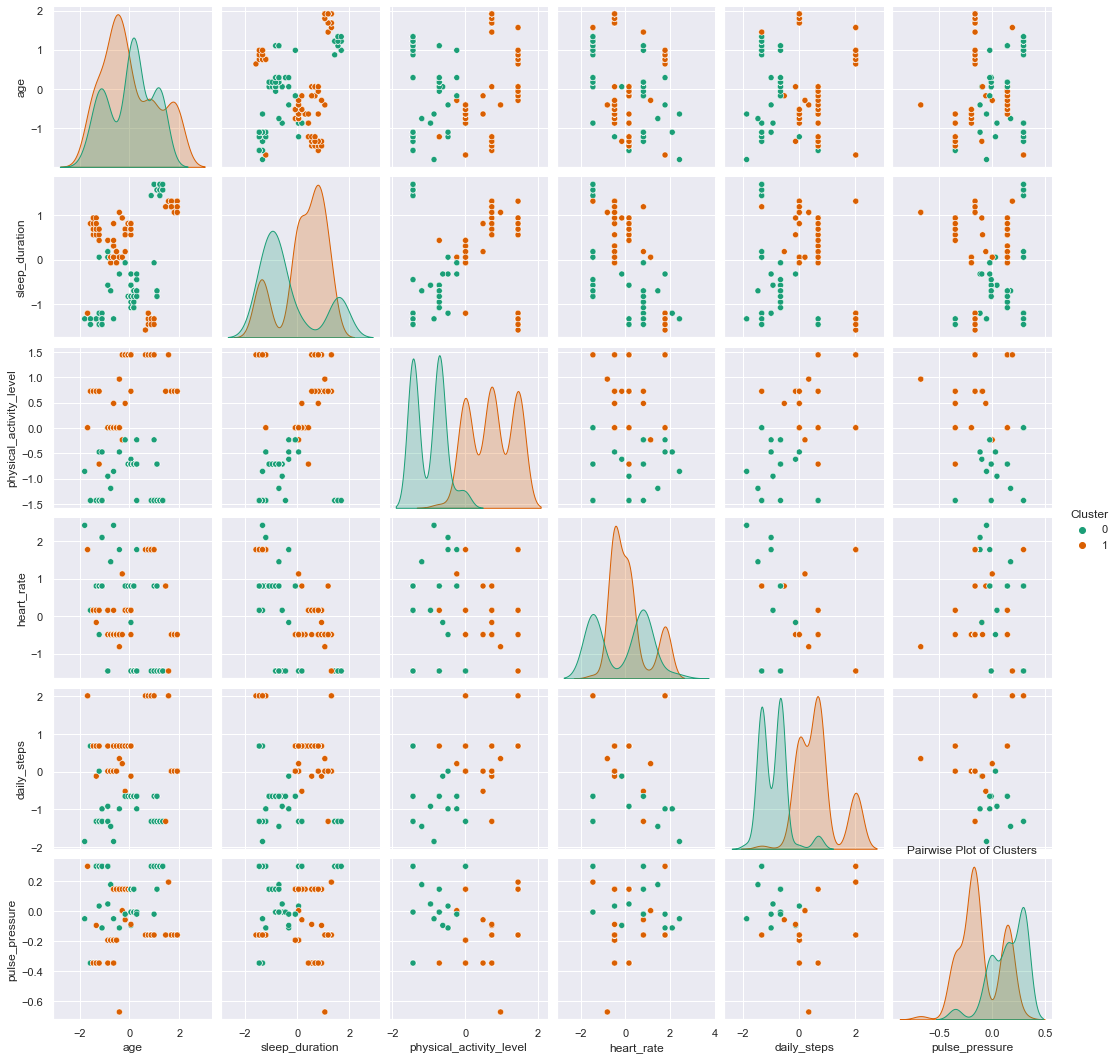

Inertia (WCSS): 1268.5917987627515
Silhouette Score: 0.35040578666962174


In [101]:
# Step 2: Perform K-Means clustering on the reduced data
kmeans = KMeans(n_clusters=2, random_state=14, init="random", n_init=30)
kmeans.fit(data_kmeans)

# Add cluster labels to the DataFrame
data_kmeans['Cluster'] = kmeans.labels_

# Create pairplot to visualize the clusters
sns.pairplot(data_kmeans, hue='Cluster', palette='Dark2')
plt.title('Pairwise Plot of Clusters')
plt.show()

# CHECKING THE CLUSTERS
# Get the inertia (WCSS)
inertia = kmeans.inertia_
print(f"Inertia (WCSS): {inertia}")

sil_score = silhouette_score(data_kmeans, kmeans.labels_)
print(f"Silhouette Score: {sil_score}")


LinAlgError: singular matrix

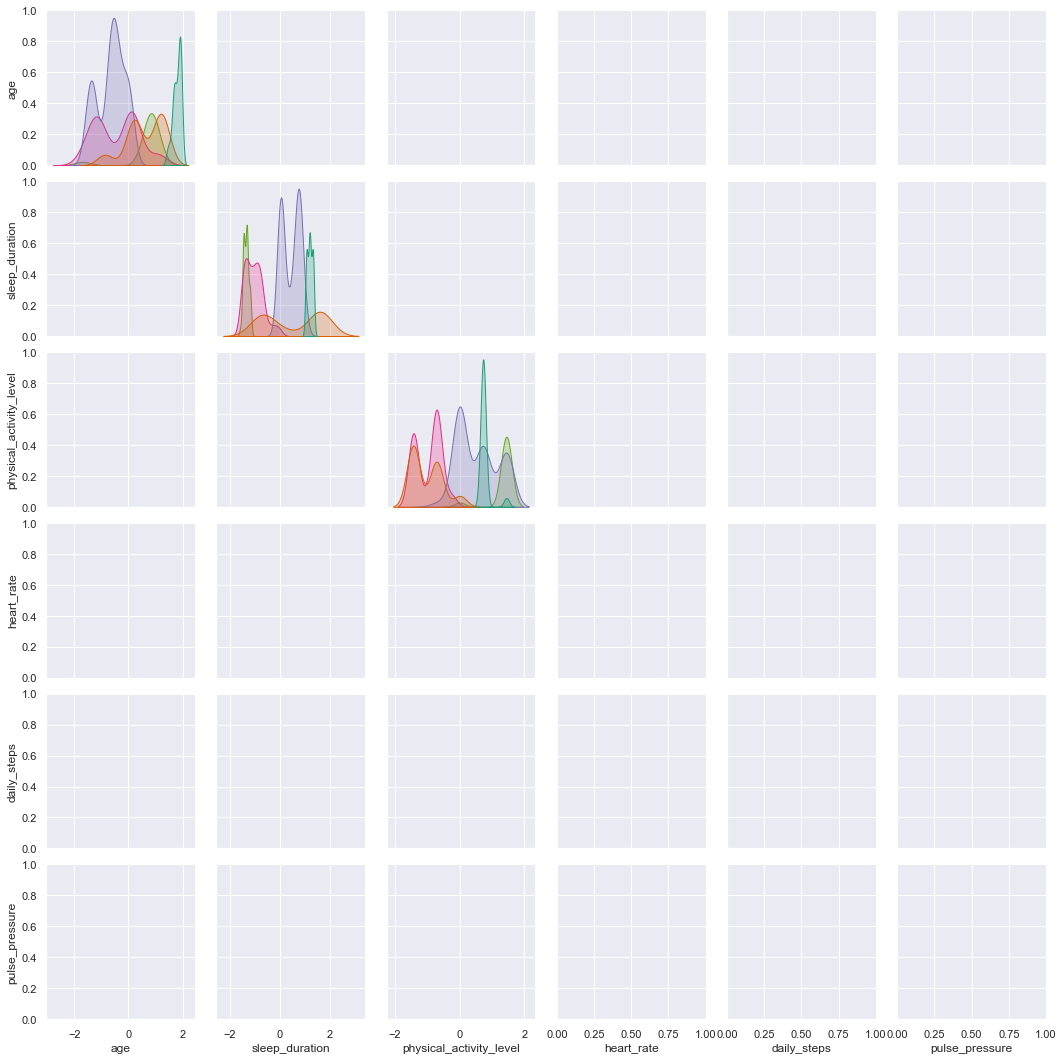

In [102]:
# Step 2: Perform K-Means clustering on the reduced data
kmeans = KMeans(n_clusters=5, random_state=14, init="random", n_init=30)
kmeans.fit(data_kmeans)

# Add cluster labels to the DataFrame
data_kmeans['Cluster'] = kmeans.labels_

# Create pairplot to visualize the clusters
sns.pairplot(data_kmeans, hue='Cluster', palette='Dark2')
plt.title('Pairwise Plot of Clusters')
plt.show()

# CHECKING THE CLUSTERS
# Get the inertia (WCSS)
inertia = kmeans.inertia_
print(f"Inertia (WCSS): {inertia}")

sil_score = silhouette_score(data_kmeans, kmeans.labels_)
print(f"Silhouette Score: {sil_score}")


# MDS

As alternative to Principal Component Analysis, Multi Dimensional Scaling (MDS) offers a distance based dimension reduction method. Input to MDS are a distance (or dissimilarity) Matrix generated by a chosen distance. This distance has to fulfill the following properties:

- Symmetry (of distance between two points, A->B = B->A)
- Non-Negativity (distance between two points must be non-negative)
- Identity of Indiscernibles (distance A->B is only zero if A=B)
- Triangular Inequality (A->C <= A->B->C)

in the following, we utilize the Mahalanobis distance and the Gower dissimilarity to set up two distance matrices, one of which will then used to apply MDS.

In [103]:
data_mds = data[numeric_variables+categorical_variables]

In [104]:
# Distance Matrix: mahalanobis

import numpy as np
from scipy.spatial.distance import mahalanobis

def maha_dist(data,
              numeric_variables):
    data_numeric = data[numeric_variables]

    # covariance matrix + inverse
    cov_matrix = np.cov(data_numeric.T)  # Transpose because rows are observations
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # empty distance matrix
    n = len(data_numeric)
    m_distance_mahalanobis = np.zeros((n, n))

    # pairwise Mahalanobis distances
    for i in range(n):
        for j in range(n):
            xi = data_numeric.iloc[i].values
            xj = data_numeric.iloc[j].values
            m_distance_mahalanobis[i, j] = mahalanobis(xi, xj, inv_cov_matrix)

    return m_distance_mahalanobis

m_distance_mahalanobis = maha_dist(data_mds,numeric_variables)

In [105]:
# Distance Matrix: Gowers
import gower
m_distance_gowers = gower.gower_matrix(data_mds)

Plotting the corresponding distance matrix is not possible, as the dataset with 374 data points is simply too big. 

In [106]:
# # Plot distance Matrices WARNING THIS TAKES A LONG TIME TO RUN
# fig, axes = plt.subplots(1, 2, figsize=(160, 60))  # Adjust size as needed

# # Plot the first heatmap
# sns.heatmap(m_distance_mahalanobis, annot=True, fmt=".1f", cmap="coolwarm", cbar=True, ax=axes[0])
# axes[0].set_title("Mahalanobis Distance Matrix")
# axes[0].set_xlabel("Points")
# axes[0].set_ylabel("Points")

# # Plot the second heatmap
# sns.heatmap(m_distance_gowers, annot=True, fmt=".1f", cmap="coolwarm", cbar=True, ax=axes[1])
# axes[1].set_title("Gower Dissimilarity Matrix")
# axes[1].set_xlabel("Points")
# axes[1].set_ylabel("Points")

With the distance/dissimilarity Matrices set up, the MDS is performed using Gowers dissimilarity matrix as it also contains the categorical/binary that can be found in the dataset data, whereas Mahalanobis distance was only created with the numerical variables. 

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

def coorp(D):

    n = D.shape[0]
    # Centering matrix & double centering distance matrix
    H = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * H @ D @ H

    # Ensure the matrix is positive semidefinite
    eigenvalues = np.linalg.eigvalsh(B)
    epsilon = 1e-6
    if np.min(eigenvalues) < -epsilon:
        raise ValueError("Matrix D is not Euclidean and needs preprocessing.")

    # Compute eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eigh(B)
    eigvals = eigvals[::-1]  # Reverse to descending order
    eigvecs = eigvecs[:, ::-1]

    # Filter non-zero eigenvalues
    positive_eigvals = eigvals > epsilon
    vaps = eigvals[positive_eigvals]
    principal_components = eigvecs[:, positive_eigvals]

    # Compute principal coordinates
    Y = principal_components * np.sqrt(vaps)

    # Variance explained
    percent = (vaps / np.sum(vaps)) * 100
    acum = np.cumsum(percent)

    return Y, vaps, percent, acum

Y, vaps, percent, acum = coorp(m_distance_gowers)

Having performed the MDS, as a first step the cumulative explained variance is plotted to show how many Principal Coordinates are required to represent the full Variance of the Data Set. The plot below shows, how 80 % of the variance can be covered with 7 Principal Components. Notable is how from the 7th principal coordinate onwards, the added variance decreases significantly as the cumulative variance goes towards 100 % 

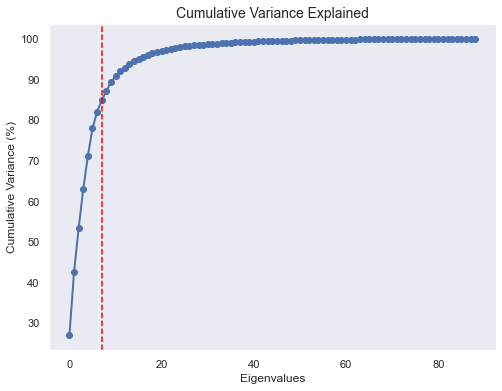

In [108]:
 # Plot cumulative variance explained
plt.figure(figsize=(8, 6))
plt.plot(acum, marker='o', linestyle='-', color='b', linewidth=2)
plt.xlabel("Eigenvalues", fontsize=12)
plt.ylabel("Cumulative Variance (%)", fontsize=12)
plt.title("Cumulative Variance Explained", fontsize=14)
plt.axvline(x=7, color='red', linestyle='--', label="Vertical line")
plt.grid()
plt.show()

Looking at the first three principal coordinates, does not give significant insight into how these principal coordinates can be interpreted. 

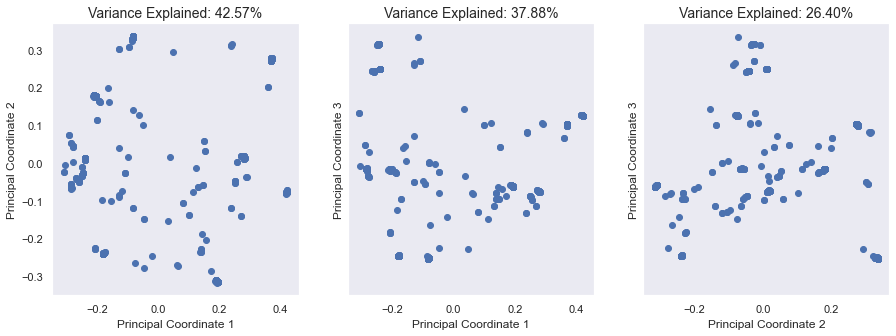

In [109]:
#for i in range(0,3):

#n  components
n_coords = 3
fig, axes = plt.subplots(1, n_coords, figsize=(15, 5), sharey=True)

axes[0].scatter(Y[:, 0], Y[:, 1], c='b', marker='o', label='Points')
axes[0].set_xlabel(f"Principal Coordinate {1}", fontsize=12)
axes[0].set_ylabel(f"Principal Coordinate {2}", fontsize=12)
axes[0].set_title(f"Variance Explained: {acum[1]:.2f}%", fontsize=14)
axes[0].grid()

axes[1].scatter(Y[:, 0], Y[:, 2], c='b', marker='o', label='Points')
axes[1].set_xlabel(f"Principal Coordinate {1}", fontsize=12)
axes[1].set_ylabel(f"Principal Coordinate {3}", fontsize=12)
axes[1].set_title(f"Variance Explained: {acum[0]+(acum[2]-acum[1]):.2f}%", fontsize=14)
axes[1].grid()

axes[2].scatter(Y[:, 1], Y[:, 2], c='b', marker='o', label='Points')
axes[2].set_xlabel(f"Principal Coordinate {2}", fontsize=12)
axes[2].set_ylabel(f"Principal Coordinate {3}", fontsize=12)
axes[2].set_title(f"Variance Explained: {acum[2]-acum[0]:.2f}%", fontsize=14)
axes[2].grid()


fig.show()

To gain a deeper understanding on how to interprete the principal coordinates, the same plot is done with a color coding of the categorical and the binary Variables. 

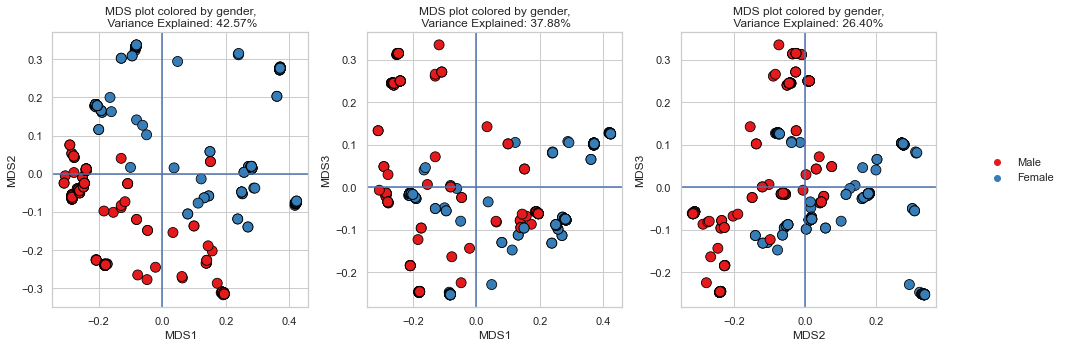

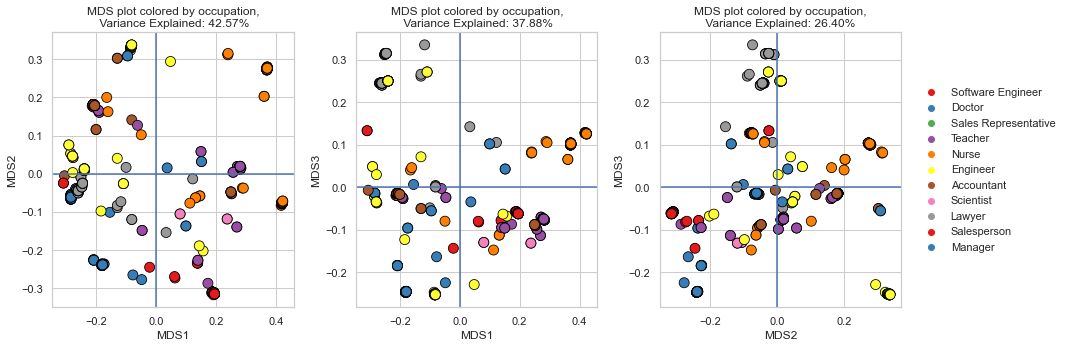

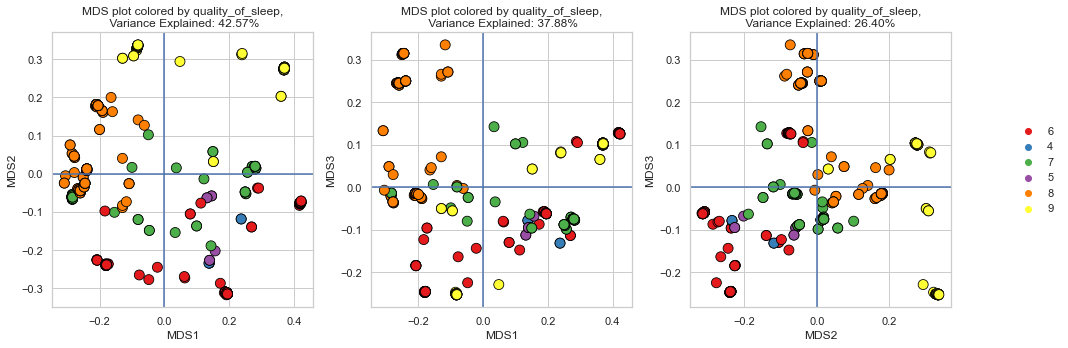

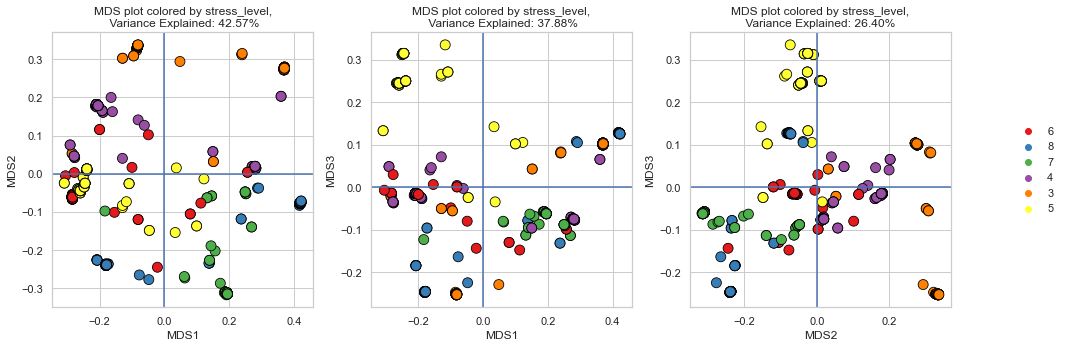

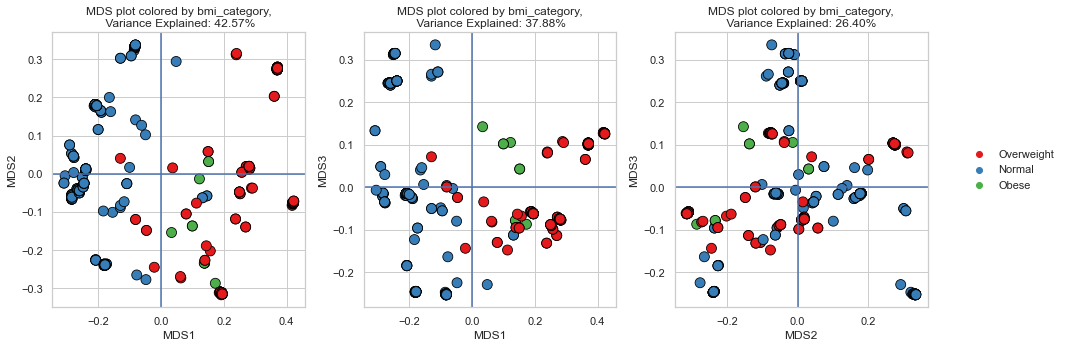

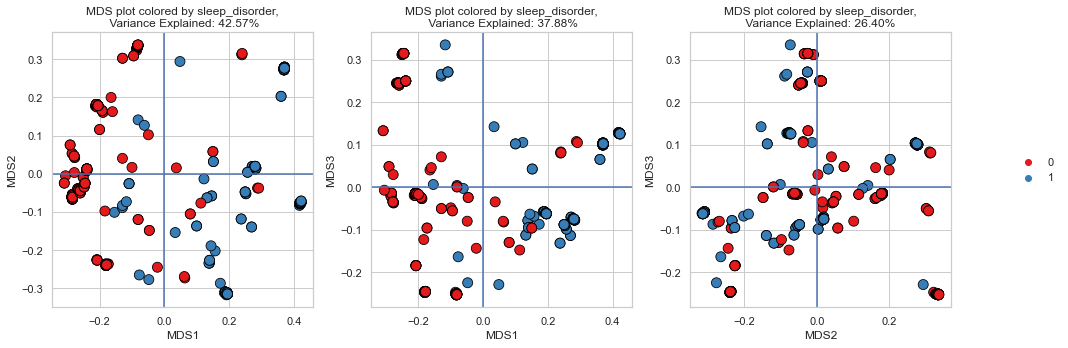

In [134]:
data_mds_output = data_mds.copy()
data_mds_output[["MDS1","MDS2","MDS3"]] = Y[:,0:3]

for i, var in enumerate(categorical_variables):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1, 0.2]})
    
    # MDS1 vs MDS2
    sns.scatterplot(
        ax=axes[0],
        data=data_mds_output,
        x='MDS1',
        y='MDS2',
        hue=var,
        palette='Set1',
        s=100,
        edgecolor='black'
    )
    axes[0].set_title(f'MDS plot colored by {var},\n Variance Explained: {acum[1]:.2f}%')
    axes[0].legend().set_visible(False) 

    
    # MDS1 vs MDS3
    sns.scatterplot(
        ax=axes[1],
        data=data_mds_output,
        x='MDS1',
        y='MDS3',
        hue=var,
        palette='Set1',
        s=100,
        edgecolor='black'
    )
    axes[1].set_title(f'MDS plot colored by {var},\n Variance Explained: {acum[0] + (acum[2] - acum[1]):.2f}%')
    axes[1].legend().set_visible(False) 

    # MDS2 vs MDS3
    sns.scatterplot(
        ax=axes[2],
        data=data_mds_output,
        x='MDS2',
        y='MDS3',
        hue=var,
        palette='Set1',
        s=100,
        edgecolor='black'
    )
    axes[2].set_title(f'MDS plot colored by {var},\n Variance Explained: {acum[2] - acum[0]:.2f}% ')
    axes[2].legend().set_visible(False) 

    # legend
    handles, labels = axes[0].get_legend_handles_labels()
    axes[3].legend(handles=handles, labels=labels, loc='center', frameon=False)
    axes[3].axis('off') 

    axes[0].axhline(0)
    axes[0].axvline(0)

    axes[1].axhline(0)
    axes[1].axvline(0)

    axes[2].axhline(0)
    axes[2].axvline(0)


    plt.tight_layout()
    plt.show()


Correlations between original Variables and first three Principal Coordinates

Index(['age', 'sleep_duration', 'physical_activity_level', 'heart_rate',
       'daily_steps', 'blood_pressure_systolic', 'blood_pressure_diastolic',
       'gender', 'occupation', 'quality_of_sleep', 'stress_level',
       'bmi_category', 'sleep_disorder'],
      dtype='object')


ConversionError: Failed to convert value(s) to axis units: Index(['age', 'sleep_duration', 'physical_activity_level', 'heart_rate',
       'daily_steps', 'blood_pressure_systolic', 'blood_pressure_diastolic',
       'gender', 'occupation', 'quality_of_sleep', 'stress_level',
       'bmi_category', 'sleep_disorder'],
      dtype='object')

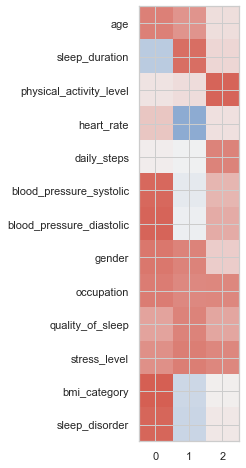

In [140]:
from scipy.stats import pearsonr, spearmanr
from scipy.stats import chi2_contingency

# Cramers V
def cramer_v(u, X):
    n = len(u)
    percentiles = np.percentile(X, [0, 25, 50, 75, 100])
    Xcat = np.ones(n)
    Xcat[(X > percentiles[1]) & (X <= percentiles[2])] = 2
    Xcat[(X > percentiles[2]) & (X <= percentiles[3])] = 3
    Xcat[X > percentiles[3]] = 4
    
    # contingency table
    cont_table = pd.crosstab(u, Xcat)
    chi2, p, dof, expected = chi2_contingency(cont_table)
    
    k = len(np.unique(u))
    r = len(np.unique(Xcat))
    
    V = np.sqrt(chi2 / (n * min(k - 1, r - 1)))
    return V

# Main correlation function
def correlaciones2(X, Y, pcuant, pnominal):
    collumns = X.columns
    print(collumns)
    X = X.to_numpy()
    p = X.shape[1]
    pordinal = p - pcuant - pnominal
    corr_table = np.zeros((p, 3))

    # quantitative variables
    for i in range(pcuant):
        corr_table[i, :] = [pearsonr(Y[:, 0], X[:, i])[0], pearsonr(Y[:, 1], X[:, i])[0], pearsonr(Y[:, 2], X[:, i])[0]]

    # nominal variables
    for i in range(pcuant, pcuant + pnominal):
        corr_table[i, :] = [cramer_v(X[:, i], Y[:, 0]), cramer_v(X[:, i], Y[:, 1]), cramer_v(X[:, i], Y[:, 2])]

    # ordinal variables
    for i in range(pcuant + pnominal, p):
        corr_table[i, :] = [spearmanr(Y[:, 0], X[:, i])[0], spearmanr(Y[:, 1], X[:, i])[0], spearmanr(Y[:, 2], X[:, i])[0]]

    # Plot
    L1 = ['PC1', 'PC2', 'PC3']    
    fig, ax = plt.subplots(figsize=(10, 8))
    cmap = sns.diverging_palette(250, 15, as_cmap=True)
    cax = ax.imshow(corr_table, cmap=cmap, vmin=-1, vmax=1)
    ax.set_yticks(np.arange(p))  # Set numeric tick positions
    ax.set_yticklabels(collumns)  # Use the actual column names as labels
    ax.set_yticks(collumns)
    ax.set_yticklabels(range(1, p+1))  # You can modify this based on your column names
    ax.set_title('Principal Coordinates Heatmap', fontsize=12)
    fig.colorbar(cax, ax=ax)
    
    plt.show()

    return corr_table



# excecute
corr_table = correlaciones2(X = data_mds[numeric_variables + categorical_variables],#.to_numpy(), 
               Y = Y[:,0:3], 
               pcuant = 7, 
               pnominal = 4)



Influence of Quantitative and Categorical Variables

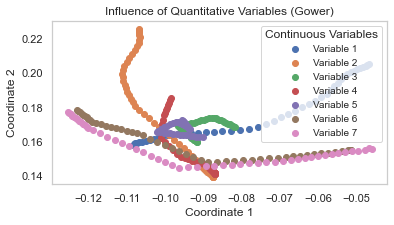

In [112]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

# def coorp_sin(D):
#     n = D.shape[0]
#     epsilon = 1.e-6

#     # Centering matrix H
#     H = np.eye(n) - np.ones((n, n)) / n
#     B = -H @ D @ H / 2

#     # Check if D is Euclidean (i.e., B >= 0)
#     L = np.linalg.eigvals(B)
#     m = np.min(L)

#     if abs(m) < epsilon:
#         # Transform D to be Euclidean (non2euclid transformation needed)
#         D = non2euclid(D)  # You need to implement this function
#         B = -H @ D @ H / 2

#     # Singular Value Decomposition (SVD) of B
#     T, Lambda, V = np.linalg.svd(B)
#     vaps = np.diag(Lambda)

#     # Extract non-zero eigenvalues and corresponding coordinates
#     j = 0
#     while j < n and vaps[j] > epsilon:
#         j += 1
#     T1 = T[:, :j]
#     X = T1 @ np.sqrt(np.diag(vaps[:j]))

#     # Percentage of variability explained by each coordinate
#     percent = (vaps / np.sum(vaps)) * 100

#     # Accumulated percentage of variability
#     acum = np.cumsum(percent)

#     return X, vaps, percent, acum

# # Notes:
# # - Implement the `non2euclid` function if D is not Euclidean.
# # - `vaps`, `percent`, and `acum` are returned as row vectors.


def influence(X, p1, p2):
    n, p = X.shape
    p3 = p - p1 - p2

    # Compute distance matrix
    if p2 + p3 == 0:
        D = squareform(pdist(X, metric='mahalanobis'))
        D2 = D ** 2
    else:
        D2 = gower.gower_matrix(data)


    # Principal coordinates
    Y, vaps, _, _ = coorp(D2)
    v = 1.0 / vaps[:Y.shape[1]]
    Lambda = np.diag(v)
    g = np.sum(Y ** 2, axis=1)

    m0 = np.min(X, axis=0)
    m1 = np.max(X, axis=0)

    if p2 + p3 == 0:  # Mahalanobis distance
        S = np.cov(X, rowvar=False)
        invS = np.linalg.inv(S)

        for k in range(p):
            step = (m1[k] - m0[k]) / 50
            Xnew = np.arange(m0[k], m1[k] + step, step).reshape(-1, 1)
            nXnew = Xnew.shape[0]
            virtual = np.zeros((nXnew, p))
            virtual[:, k] = Xnew[:, 0]

            dnew = np.zeros((nXnew, n))
            for i in range(nXnew):
                for j in range(n):
                    diff = virtual[i, :] - X[j, :]
                    dnew[i, j] = diff @ invS @ diff.T

            ynew = np.zeros((nXnew, Y.shape[1]))
            for i in range(nXnew):
                ynew[i, :] = 0.5 * (g - dnew[i, :]) @ Y @ Lambda

            plt.figure(1)
            plt.plot(ynew[:, 0], ynew[:, 1], 'ob')
            plt.title("Influence of Quantitative Variables (Mahalanobis)", fontsize=12)
            plt.xlabel('Coordinate 1')
            plt.ylabel('Coordinate 2')
            plt.grid()

    else:  # Gower distance
        for k in range(p1):
            step = (m1[k] - m0[k]) / 50
            Xnew = np.arange(m0[k], m1[k] + step, step).reshape(-1, 1)
            nXnew = Xnew.shape[0]
            virtual = np.zeros((nXnew, p))
            virtual[:, k] = Xnew[:, 0]

            dnew = np.zeros((nXnew, n))
            for i in range(nXnew):
                Xvirtual = np.vstack([X, virtual[i, :]])
                D2new = gower.gower_matrix(Xvirtual)
                dnew[i, :] = D2new[-1, :-1]

            ynew = np.zeros((nXnew, Y.shape[1]))
            for i in range(nXnew):
                ynew[i, :] = 0.5 * (g - dnew[i, :]) @ Y @ Lambda

            plt.figure(1)
            plt.plot(ynew[:, 0], ynew[:, 1], label=f'Variable {k+1}', marker='o', linestyle='None')
            plt.legend(title="Continuous Variables", fontsize=10)
            plt.title("Influence of Quantitative Variables (Gower)", fontsize=12)
            plt.xlabel('Coordinate 1')
            plt.ylabel('Coordinate 2')
            plt.grid()

            # Plot for binary/qualitative variables
        # for k in range(p1, p):
        #     # Create new values for the k-th variable (qualitative or binary)
        #     Xnew = np.unique(X[:, k])  # Get unique values of the k-th variable
        #     nXnew = len(Xnew)
        #     virtual = np.zeros((nXnew, p))
        #     virtual[:, k] = Xnew
            
        #     dnew = np.zeros((nXnew, n))
            
        #     # Loop through each new value of the k-th variable and compute distances
        #     for i in range(nXnew):
        #         Xvirtual = np.vstack([X, virtual[i, :]])  # Add the virtual individual
        #         D2new = gower.gower_matrix(Xvirtual)  # Compute Gower distance
        #         dnew[i, :] = D2new[-1, :-1]  # Get distances for the original individuals

        #     # Interpolate Gower distances and project onto MDS space
        #     ynew = np.zeros((nXnew, 2))  # Initialize array for MDS projections
        #     for i in range(nXnew):
        #         #print(ynew[i, :].shape, g.shape, dnew[i, :].reshape((-1,1)).shape, Y.shape, Lambda.shape)
        #         ynew[i, :] = 0.5 * (g - dnew[i, :].reshape((-1,1))) @ Y @ Lambda

        #     # Plot the influence of the k-th variable (qualitative or binary)
        #     plt.figure()
        #     plt.plot(ynew[:, 0], ynew[:, 1], 'ob')
        #     plt.title(f'Influence of the variable {k + 1} (Gower)')
        #     plt.show()

plt.show()


from sklearn.preprocessing import LabelEncoder

# Assuming 'data' is your DataFrame and 'categorical_variables' is a list of column names for categorical variables
label_encoder = LabelEncoder()

data_encoded = data.copy()
for col in categorical_variables:
    data_encoded[col] = label_encoder.fit_transform(data[col])


influence(X=data_encoded[numeric_variables+categorical_variables].to_numpy(), p1= 7, p2 = 4)



Sensitivity of principal coordinates: 
- 1st via matlab scripts
- 2nd via sklearn

In [113]:
def coorp_complet(D):
    # This function needs to compute the principal coordinates of the full dataset
    # (multidimensional scaling or classical MDS) and return the coordinates and cumulative percentage
    pass

def coorp_minus(Di):
    # This function computes the principal coordinates after removing one individual
    # (multidimensional scaling or classical MDS) and returns the coordinates and eigenvalues
    pass

def sensitividad_Gower(Xdat, p1, p2):
    n, p = Xdat.shape
    p3 = p - p1 - p2
    
    # Calculate the Gower similarity matrix
    D = gower.gower_matrix(Xdat)
    
    # Principal coordinates for the full dataset
    #Ycomplet, percentacum = coorp_complet(D)
    Ycomplet, vaps, percentacum, acum = coorp(D)


    # Leave-one-out sensitivity analysis
    v = np.zeros((n, n))  # Initialize the matrix for squared distances
    for i in range(n):
        print(Xdat)
        Xdati = np.delete(Xdat, i, axis=0)
        Si = gower.gower_matrix(Xdati)
        Di = np.ones((n - 1, n - 1)) - Si
        
        # Principal coordinates after removing the i-th individual
        #Y, Lambda0 = coorp(Di)
        Y, vaps, _, _ = coorp(Di)
        v = 1.0 / vaps[:Y.shape[1]]
        Lambda0 = np.diag(v)
        g = np.diag(Y @ Y.T)
        d = np.delete(D[:, i], i)  # Remove the i-th row and column
        
        # Interpolation of the i-th individual
        y = 0.5 * (g - d) @ Y @ np.linalg.inv(Lambda0)
        
        # Insert the i-th individual back into the dataset
        Yplusi = np.insert(Y, i, y, axis=0)
        
        # Calculate squared Euclidean distances
        for j in range(n):
            v[j, i] = np.sum((Yplusi[j, :] - Ycomplet[j, :]) ** 2)
    
    v = np.sqrt(v)
    
    # Hyper-sphere radii (quantiles)
    radius = np.quantile(v, 0.95, axis=1)
    
    # Theta for circle plotting
    theta = np.arange(0, 2 * np.pi, 0.12)
    
    # 2D graphical representation
    plt.figure(1)
    plt.plot(Ycomplet[:, 0], Ycomplet[:, 1], '.b')
    
    for i in range(n):
        for j in range(len(theta)):
            circle_x = Ycomplet[i, 0] + np.cos(theta[j]) * radius[i]
            circle_y = Ycomplet[i, 1] + np.sin(theta[j]) * radius[i]
            plt.plot(circle_x, circle_y, '.k', markersize=4)
    
    plt.title(f'Porcentaje de variabilidad explicada {percentacum}%', fontsize=12)
    plt.show()


sensitividad_Gower(data[numeric_variables+categorical_variables], p1= 7, p2 = 4)

     age  sleep_duration  physical_activity_level  heart_rate  daily_steps  \
0     27             6.1                       42          77         4200   
1     28             6.2                       60          75        10000   
2     28             6.2                       60          75        10000   
3     28             5.9                       30          85         3000   
4     28             5.9                       30          85         3000   
..   ...             ...                      ...         ...          ...   
369   59             8.1                       75          68         7000   
370   59             8.0                       75          68         7000   
371   59             8.1                       75          68         7000   
372   59             8.1                       75          68         7000   
373   59             8.1                       75          68         7000   

     blood_pressure_systolic  blood_pressure_diastolic  gender 

ValueError: Shape of passed values is (373, 13), indices imply (374, 13)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


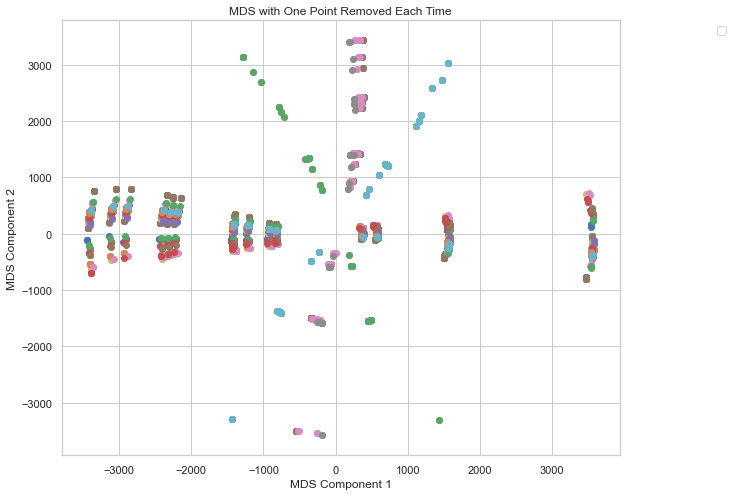

In [115]:
# THIS TAKE A LONG TIME !!!
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder

# Function to preprocess the data (encode categorical columns)
def preprocess_data(data):
    # Apply Label Encoding to all categorical columns
    le = LabelEncoder()
    data_encoded = data.copy()
    
    for column in data_encoded.select_dtypes(include=['object']).columns:
        data_encoded[column] = le.fit_transform(data_encoded[column])
    
    return data_encoded

# Function to plot MDS after removing one point at a time
def plot_mds(data):
    # Preprocess data: convert categorical columns to numeric
    data_encoded = preprocess_data(data)
    
    # Initialize the MDS object
    mds = MDS(n_components=2, dissimilarity='euclidean', random_state=42)
    
    # Create a plot
    plt.figure(figsize=(10, 8))
    
    # Perform MDS by removing one point at a time
    for i in range(len(data_encoded)):
        # Remove the i-th row (point) from the data
        data_removed = data_encoded.drop(data_encoded.index[i])
        
        # Fit MDS to the remaining data
        mds_fit = mds.fit_transform(data_removed)
        
        # Plot the first two principal coordinates (MD coordinates)
        plt.scatter(mds_fit[:, 0], mds_fit[:, 1])
    
    # Customize plot
    plt.title('MDS with One Point Removed Each Time')
    plt.xlabel('MDS Component 1')
    plt.ylabel('MDS Component 2')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.grid(True)
    plt.show()

# Example usage (assuming 'data' is your dataframe)
# plot_mds(data)

plot_mds(data[numeric_variables+categorical_variables].head(100))